<h1>Предсказание температуры стали в промышленности

---
**Описание проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

---
**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

---
**Задача**

Построить модель, которая предскажет температуру стали.

---
**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём)
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время)
- `data_gas_new.csv` — данные о продувке сплава газом
- `data_temp_new.csv` — результаты измерения температуры
- `data_wire_new.csv` — данные о проволочных материалах (объём)
- `data_wire_time_new.csv` — данные о проволочных материалах (время)

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

---

**План решения задачи:**

1. [Загрузка и обзор данных](#chapter1)

2. [Разведочный анализ данных](#chapter2)
3. [Предобработка данных](#chapter3)
    1. [Удаление выбросов](#chapter3.1)
    2. [Обработка пропусков](#chapter3.2)
    3. [Обработка признаков](#chapter3.3)
    4. [Объединение таблиц](#chapter3.4)
    5. [Общий вывод](#chapter3.5)

4. [Подготовка данных к обучению модели](#chapter4)
    1. [Разбиение данных на обучающую и тестовую выборки](#chapter4.1)
    2. [Нормализация или стандартизация данных](#chapter4.2)
    3. [Общий вывод](#chapter4.3)

5. [Выбор и обучение модели](#chapter5)
    1. [Построение дамми-модели для определения минимальной константы](#chapter5.1)
    2. [Подбор гиперпараметров, обучение модели на тренировочной выборке и сравнение результатов моделей](#chapter5.2)
    3. [Предсказание температуры на тестовой выборке с помощью выбранной модели](#chapter5.3)
    4. [Оценка качества предсказаний с использованием метрики и анализ важности признаков](#chapter5.4)

7. [Итоговый вывод](#chapter6)

---

<h2><a id="chapter1"></a>Загрузка данных</h2>


Импортируем нужные для работы библиотеки и загрузим рабочие файлы.

In [1]:
import os
import warnings
import optuna
import time
import shap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold

# настройки
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

#константы
SEED = 61023

In [2]:
# Пути к файлам
if os.path.exists('C:/jupyter/final_project'):
    path = 'C:/jupyter/final_project/'
else:
    path = '/datasets/'

In [3]:
# Загрузка данных
data_arc = pd.read_csv(path + 'data_arc_new.csv')
data_bulk = pd.read_csv(path + 'data_bulk_new.csv')
data_bulk_time = pd.read_csv(path + 'data_bulk_time_new.csv')
data_gas = pd.read_csv(path + 'data_gas_new.csv')
data_temp = pd.read_csv(path + 'data_temp_new.csv')
data_wire = pd.read_csv(path + 'data_wire_new.csv')
data_wire_time = pd.read_csv(path + 'data_wire_time_new.csv')

Приведем названия всех столбцов к стилю `snake_case` для удобства.

In [4]:
# Функция для переименования столбцов
def format_column_names(df):
    # Замена пробелов на _ и приведение к нижнему регистру
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

dfs = [
    data_arc, 
    data_bulk, 
    data_bulk_time, 
    data_gas, 
    data_temp, 
    data_wire, 
    data_wire_time
]

# Применение функции к каждому датафрейму
dfs = [format_column_names(df) for df in dfs]

# Распаковка списка
data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time = dfs

---

<h2><a id="chapter2"></a>Разведочный анализ данных</h2>

Проведем анализ данных:

1. Проверим уникальные значения `key` у каждого датасета
2. Рассмотрим каждый датасет отдельно и изучим в нем:
    - общую информацию
    - статистические характеристики
    - дубликаты
    - пропуски
3. Для наглядности построим графики и изучим особенности данных
4. Сделаем выводы

In [5]:
# Проверка количества уникальных значений key
for i in dfs:
    print(i['key'].nunique())

3214
3129
3129
3239
3216
3081
3081


Количество уникальных значений партий в каждом датасете (кроме `data_bulk` и `data_bulk_time`) разное. При объединении датасетов будем опираться только на `key`, присутствующий в обоих таблицах.

Напишем функцию для вывода основной информации о датафрейме. Изучим каждый датасет.

In [6]:
# Функция для вывода основной информации о датафрейме
def explore_data(df, name):
    print('-' * 40)
    print(f'\nИсследование данных для {name}\n')
    
    display(df.head())
    display(df.tail())
    
    print('\n----- Общая информация -----\n')
    print(f'Размерность датасета:{df.shape}\n')
    display(df.info())
    
    print('\n----- Статистические характеристики -----\n')
    display(df.describe())
    
    print('\n----- Количество дубликатов -----\n')
    print(df.duplicated().sum())
          
    print('\n----- Количество пропусков -----\n')
    print(df.isna().sum().sort_values(ascending=False))
    print('\n')

---
<h3>Данные об электродах

Изучим тип данных.

In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало_нагрева_дугой  14876 non-null  object 
 2   конец_нагрева_дугой   14876 non-null  object 
 3   активная_мощность     14876 non-null  float64
 4   реактивная_мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Начало и конец нагрева дугой представлены типом данных `object`. Переведем их в тип данных `datetime`.

In [8]:
for column in data_arc.columns[1:3]:
    data_arc[column] = pd.to_datetime(data_arc[column], 
                                      format='%Y-%m-%d %H:%M:%S')

Изучим данные.

In [9]:
explore_data(data_arc, 'data_arc')

----------------------------------------

Исследование данных для data_arc



,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347



----- Общая информация -----

Размерность датасета:(14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None


----- Статистические характеристики -----



,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485



----- Количество дубликатов -----

0

----- Количество пропусков -----

key                     0
начало_нагрева_дугой    0
конец_нагрева_дугой     0
активная_мощность       0
реактивная_мощность     0
dtype: int64




Из полученных данных видим, что пропусков и дубликатов нет. Также видим значение `-715.479924` как минимальное значение в столбце `реактивная_мощность`. Выглядит странно, скорее всего выброс. Остальные показатели выглядят нормально.

Построим несколько графиков.

**1. KDE и Boxplot для активной мощности**

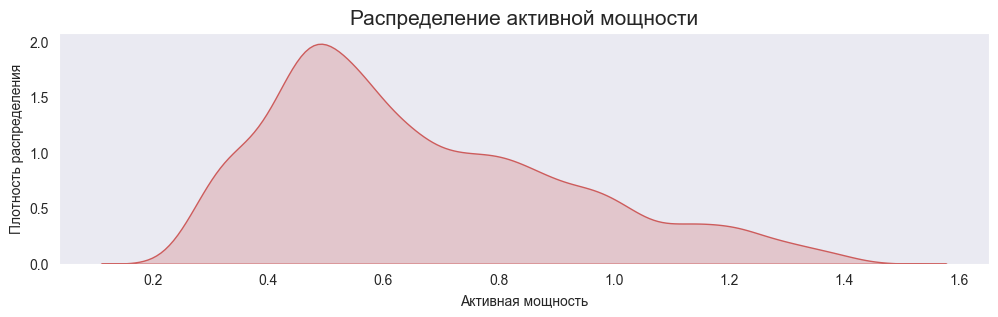

In [10]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc['активная_мощность'], color='indianred', legend=True, fill=True)
plt.xlabel('Активная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение активной мощности', fontsize=15)
plt.grid();

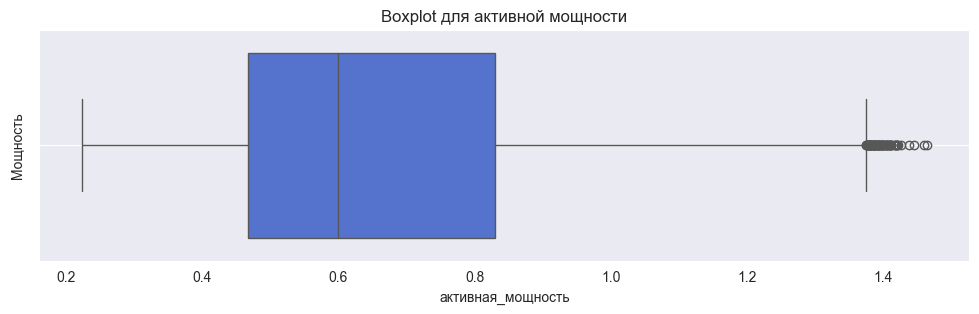

In [11]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc['активная_мощность'], color='royalblue', orient='h')
plt.title('Boxplot для активной мощности')
plt.ylabel('Мощность')
plt.grid();

Распределение выглядит нормально. 
Основное значение активной мощности сконцентрированно в промежутке 0.4 - 0.6, а медиана находится около значения 0.6.

**2. KDE и Boxplot для реактивной мощности**

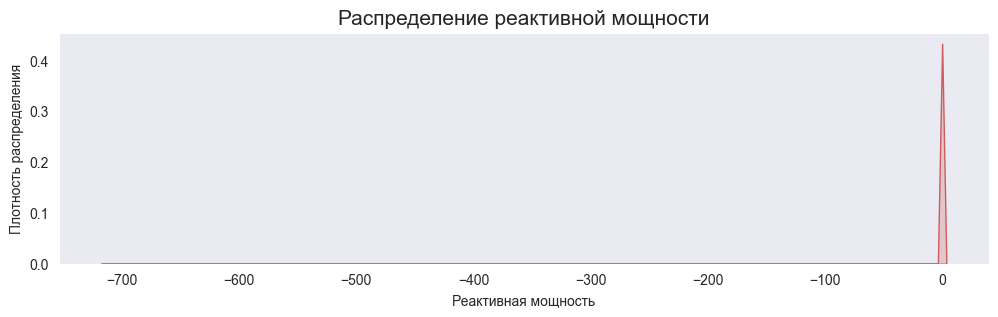

In [12]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc['реактивная_мощность'], color='indianred', legend=True, fill=True)
plt.xlabel('Реактивная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение реактивной мощности', fontsize=15)
plt.grid();

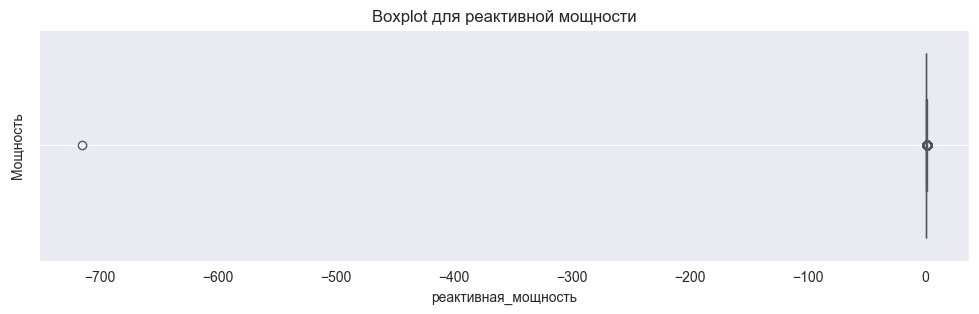

In [13]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc['реактивная_мощность'], color='royalblue', orient='h')
plt.title('Boxplot для реактивной мощности')
plt.ylabel('Мощность')
plt.grid();

Отрицательное значение которые мы заметили раньше всё-таки оказалось выбросом.

В реальных системах реактивная мощность может быть как положительной, так и отрицательной, в зависимости от того, действует ли система преимущественно как индуктивное или емкостное сопротивление. В контексте нашего проекта и процесса нагревания металла электродами, наличие отрицательной реактивной мощности кажется необычным. Это может указывать на ошибку в измерениях или записях, на особенности оборудования или процесса или на другие факторы.

Однако в виду того, что это значение в нашем датасете единичное, предположим что это всё-таки выброс. На всякий случай стоит уточнить этот вопрос у заказчика.

Далее нам необходимо построить несколько графиков зависимостей. Сначала построим их учитывая этот выброс, а потом удалим его и изучим графики ещё раз.

**3. Heatmap корреляции мощностей**

In [14]:
def corr_matrix(df):   
    correlation_matrix = df[['активная_мощность', 'реактивная_мощность']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title('Корреляция между активной и реактивной мощностью');

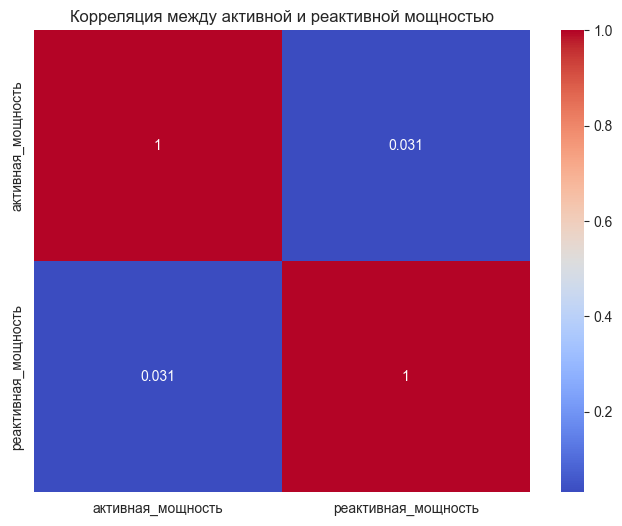

In [15]:
corr_matrix(data_arc)

Видим, что корреляция между мощностями низкая.

**4. Связь между активной и реактивной мощностями**

In [16]:
def scatter_plot(df): 
    plt.figure(figsize=(12, 3))
    plt.scatter(df['активная_мощность'], df['реактивная_мощность'], color='royalblue')
    plt.title('Связь активной и реактивной мощности')
    plt.xlabel('Активная мощность')
    plt.ylabel('Реактивная мощность');

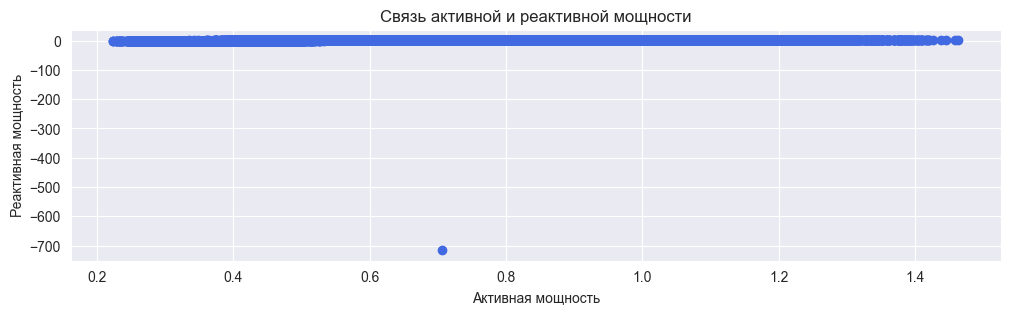

In [17]:
scatter_plot(data_arc)

График выглядит так, будто независимо от изменений в активной мощности, реактивная мощность остается постоянной. Выброс в реактивной мощности мешает увидеть настоящую картину.

5. Зависимость мощностей от времени

In [18]:
def time_power(df):
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

    axes[0].plot(df['начало_нагрева_дугой'], df['активная_мощность'], label='Активная мощность', color='#A18594')
    axes[0].set_title('Динамика активной мощности во времени')
    axes[0].set_ylabel('Активная мощность')
    axes[1].plot(df['начало_нагрева_дугой'], df['реактивная_мощность'], label='Реактивная мощность', color='royalblue')
    axes[1].set_title('Динамика реактивной мощности во времени')
    axes[1].set_xlabel('Дата')
    axes[1].set_ylabel('Реактивная мощность');

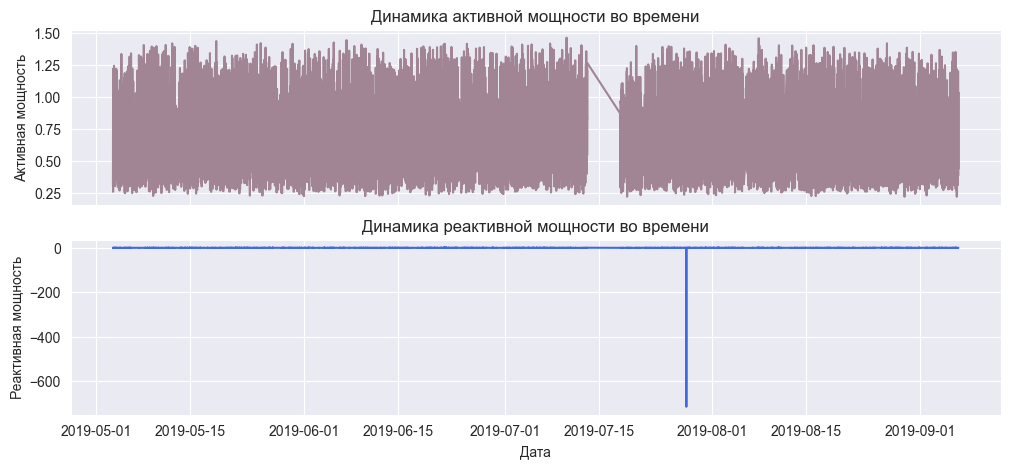

In [19]:
time_power(data_arc)

Из графика динамики мощностей во времени видно, что:
- присутсвует временной период, где записи отсутствуют
- в реактивной мощности есть выброс, скорее всего из-за этого графики не похожи в месте, где записи отсутствуют

Возьмем примерный временной промежуток где нет записей и убедимся в их отсутствии

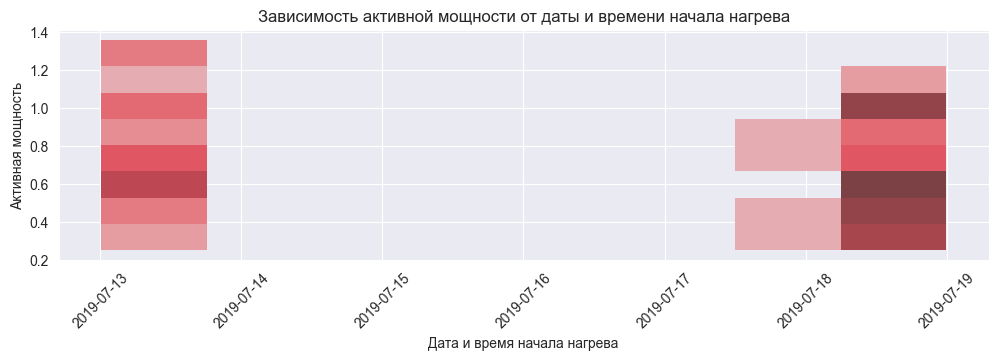

In [20]:
filtered_data = data_arc[(data_arc['начало_нагрева_дугой'] >= '2019-07-13') 
                         & (data_arc['начало_нагрева_дугой'] <= '2019-07-19')]

plt.figure(figsize=(12, 3))
sns.histplot(x=filtered_data['начало_нагрева_дугой'], 
             y=filtered_data['активная_мощность'], 
             color='#E4717A')
plt.title('Зависимость активной мощности от даты и времени начала нагрева')
plt.xlabel('Дата и время начала нагрева')
plt.ylabel('Активная мощность')
plt.xticks(rotation=45);

In [21]:
start_date = '2019-07-13 06'
end_date = '2019-07-18 08'
filtered_data = data_arc[(data_arc['начало_нагрева_дугой'] >= start_date) & (data_arc['начало_нагрева_дугой'] <= end_date)]

display(filtered_data)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
8728,1899,2019-07-13 06:29:57,2019-07-13 06:32:04,0.818657,0.559263
8729,1899,2019-07-13 06:39:22,2019-07-13 06:47:43,1.212893,0.912544
8730,1899,2019-07-13 06:49:09,2019-07-13 06:52:24,0.547938,0.391525
8731,1899,2019-07-13 06:53:45,2019-07-13 06:57:08,0.757284,0.505066
8732,1899,2019-07-13 06:59:31,2019-07-13 07:00:27,1.267711,1.017864
8733,1900,2019-07-18 05:12:00,2019-07-18 05:13:16,0.872761,0.767688
8734,1900,2019-07-18 05:17:58,2019-07-18 05:21:53,0.418361,0.365692
8735,1900,2019-07-18 05:46:10,2019-07-18 05:50:41,0.785243,0.524853
8736,1900,2019-07-18 05:57:22,2019-07-18 06:00:55,0.293737,0.250828
8737,1900,2019-07-18 06:04:18,2019-07-18 06:05:47,0.969985,0.916705


Действительно, с утра 13 по утро 18 записей в датасете нет. Возможно произошел сбой при записи данных или их выгрузке. Стоит уточнить у заказчика.

**6. Зависимость без выброса реактивной мощности**

Удалим объект моделиования, в реактивной мощности которого был замечен отрицательный выброс. Взглянем на графики.

In [22]:
data_arc[data_arc['реактивная_мощность'] < 0]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [23]:
data_arc_copy = data_arc.drop(data_arc.query('key == 2116').index).reset_index(drop=True)

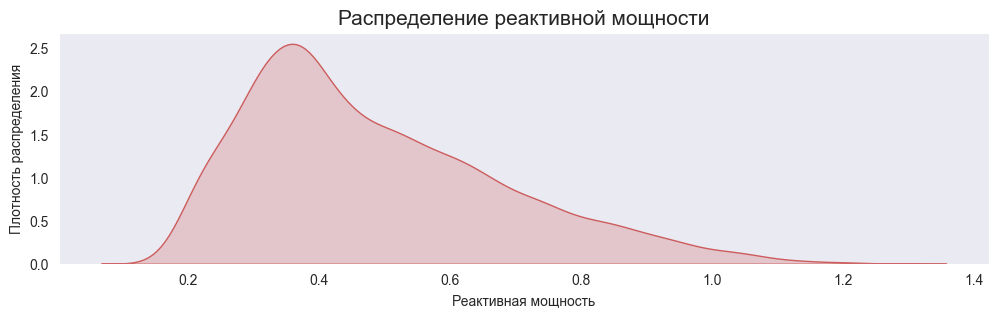

In [24]:
plt.figure(figsize=(12, 3))

sns.kdeplot(data_arc_copy['реактивная_мощность'], color='indianred', legend=True, fill=True)
plt.xlabel('Реактивная мощность')
plt.ylabel('Плотность распределения')
plt.title('Распределение реактивной мощности', fontsize=15)
plt.grid();

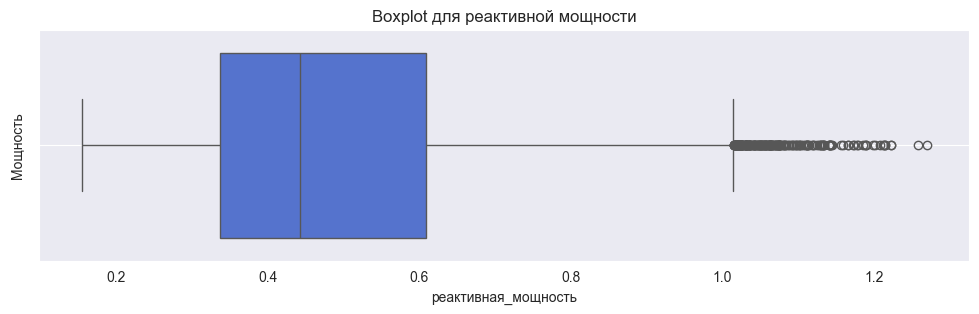

In [25]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=data_arc_copy['реактивная_мощность'], color='royalblue', orient='h')
plt.title('Boxplot для реактивной мощности')
plt.ylabel('Мощность')
plt.grid();

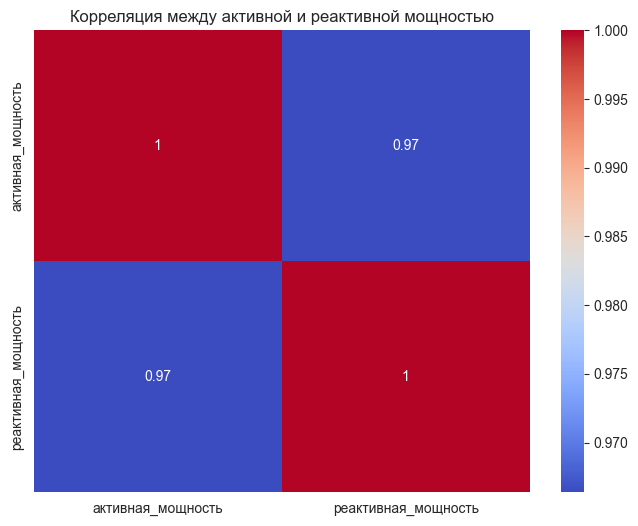

In [26]:
corr_matrix(data_arc_copy)

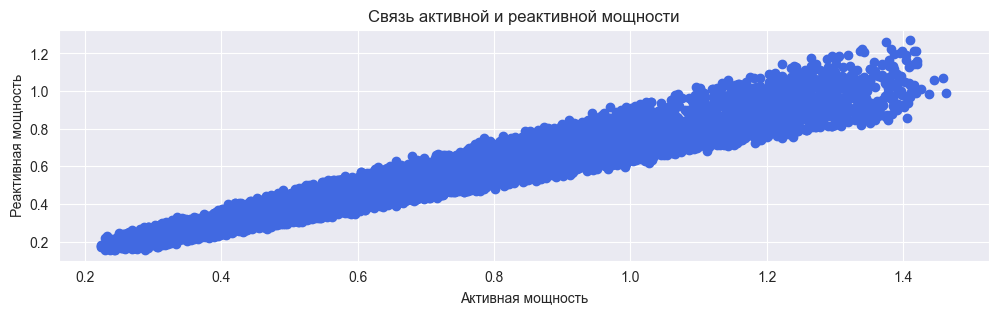

In [27]:
scatter_plot(data_arc_copy)

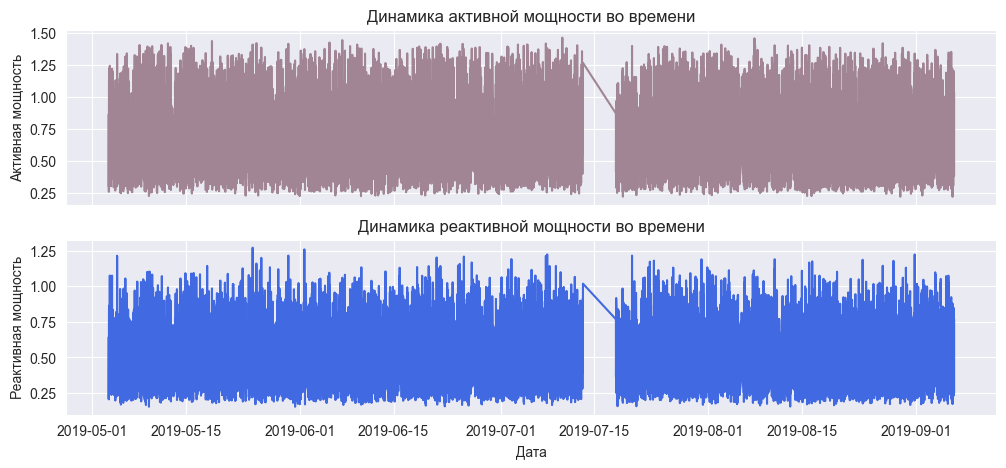

In [28]:
time_power(data_arc_copy)

Без аномального значения графики выглядят совсем по другому - теперь и мощности имеют высокую корреляцию, и пропуски в данных совпадают.

Высокая корреляция между мощностями не является чем-то удивительным, однако при использовании линейных регрессионых моделей высокая корреляция может привести к проблемам мультиколлинеарности. Стоит или исключить один из коррелирующих признаков, или применить методы регуляризации.

<h4>Вывод

В датасете `data_arc`:

- Нет дубликатов
- Нет пропусков в столбцах
- В реактивной мощности есть отрицательный выброс
- С 13 по 18 июля 2019 года не было записей о работе
- 18 июля были какие-то задержки в работе
- Без выброса данные линейно зависимы
- Имеются данные с `2019-05-03` по `2019-09-06`

---
<h3>Данные о подаче сыпучих материалов (объём)

Изучим данные.

In [29]:
explore_data(data_bulk, 'data_bulk')

----------------------------------------

Исследование данных для data_bulk



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0



----- Общая информация -----

Размерность датасета:(3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None


----- Статистические характеристики -----



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



----- Количество дубликатов -----

0

----- Количество пропусков -----

bulk_8     3128
bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64




В датасете нет дубликатов, однако присутствуют пропуски во всех столбцах кроме `key`. 

Судя по всему, за каждую итерацию могут засыпать разное количество видов материала - или один, или сразу несколько.

Построим графики.

In [30]:
# Не будем брать key для графиков
bulk_columns = [col for col in data_bulk.columns if "bulk_" in col]

**1. Boxplot для всех материалов**

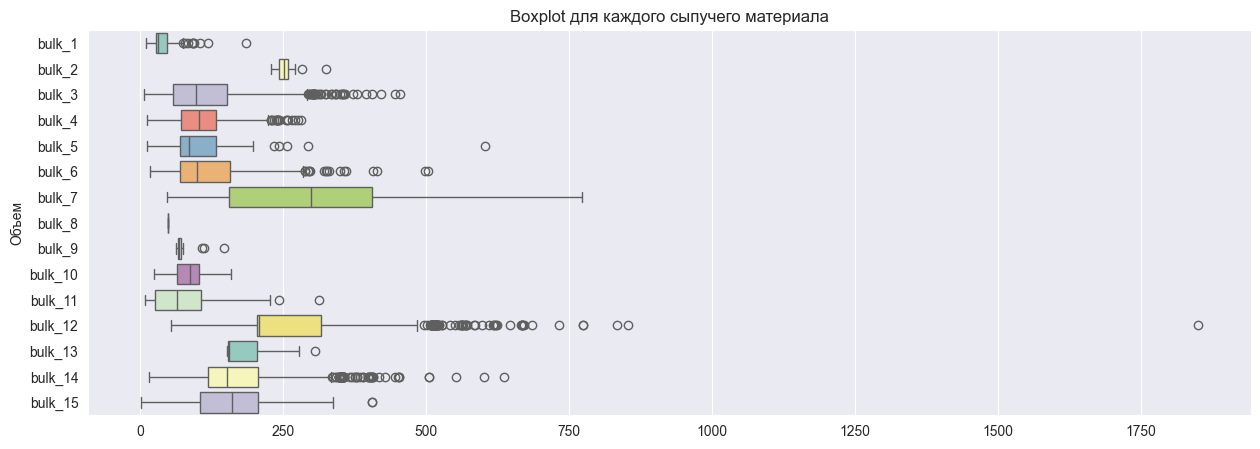

In [31]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=data_bulk[bulk_columns], orient='h', palette='Set3')
plt.title('Boxplot для каждого сыпучего материала')
plt.ylabel('Объем')
plt.show()

Отрицательных значений нет. Виден выброс у `wire_12`. У нескольких материалов есть "хвосты".

**2. Распределение количества материала**

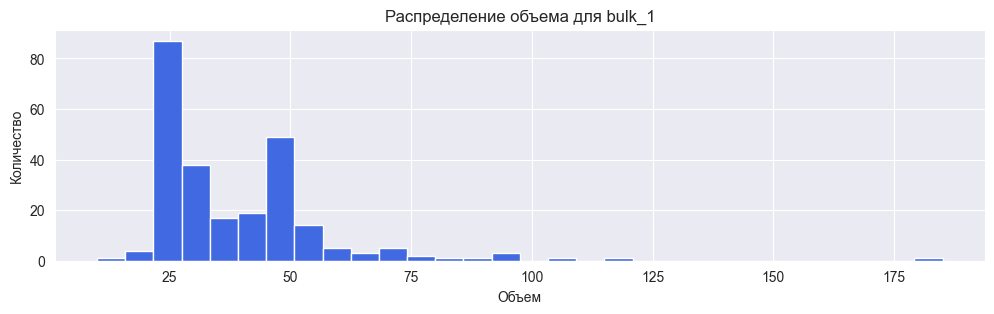

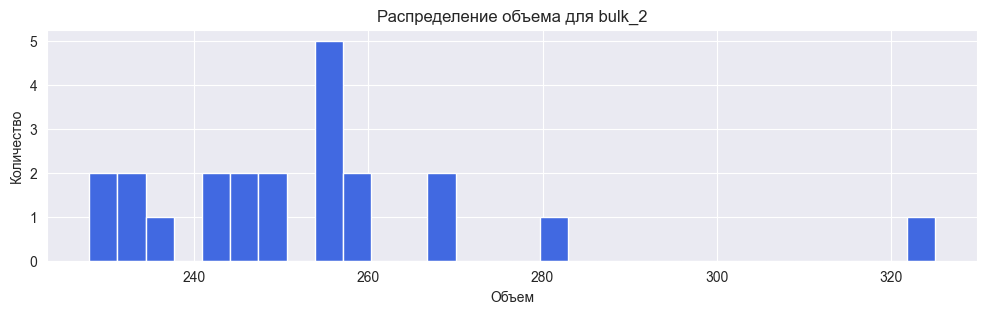

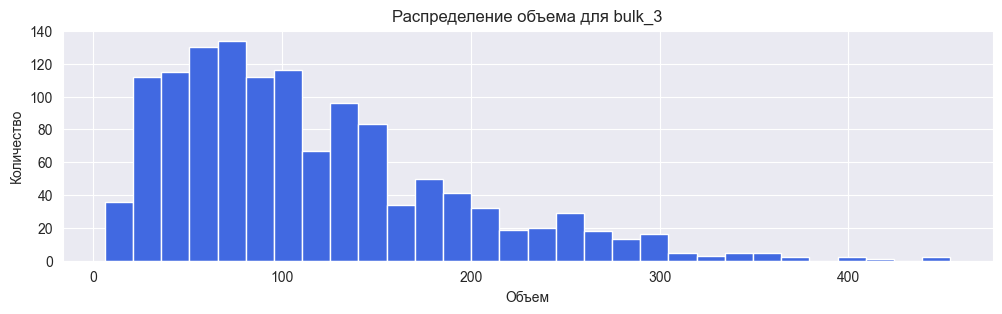

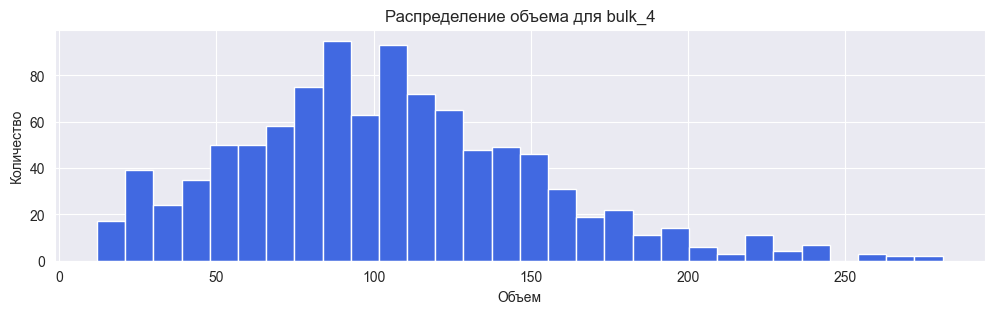

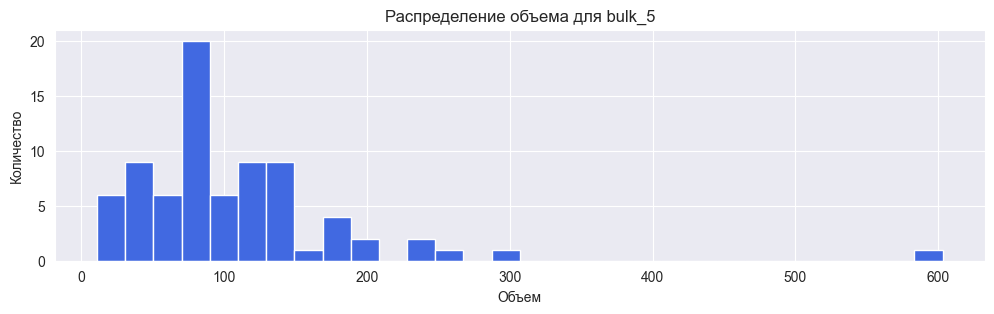

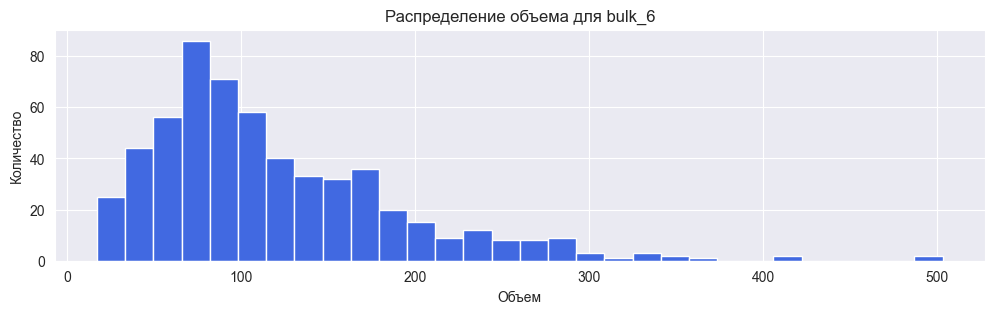

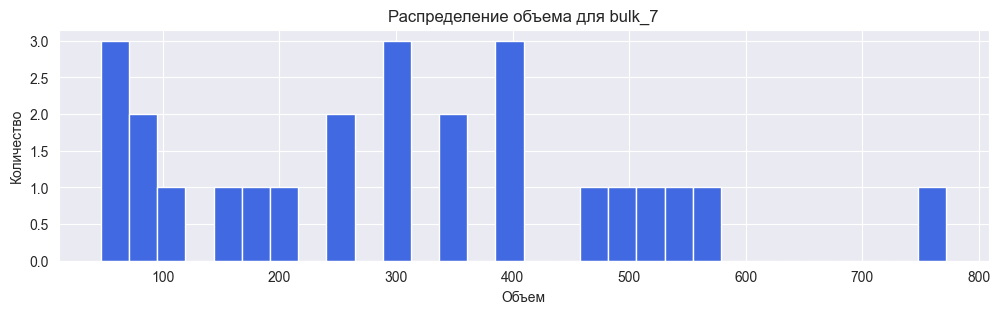

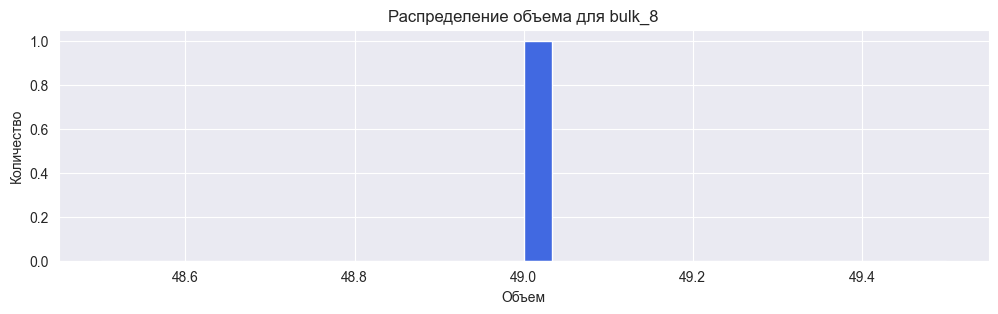

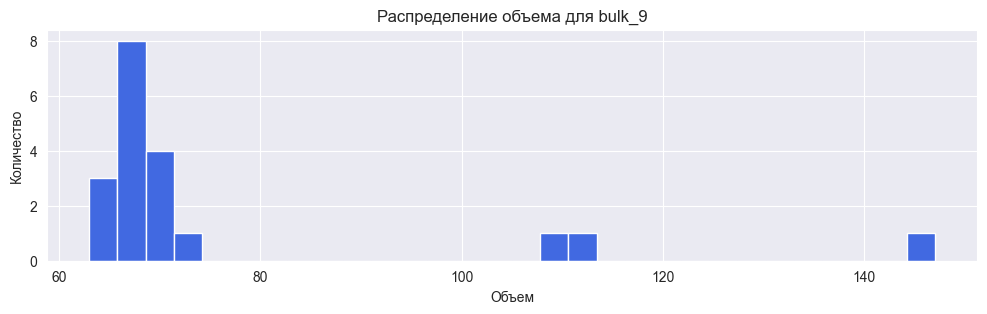

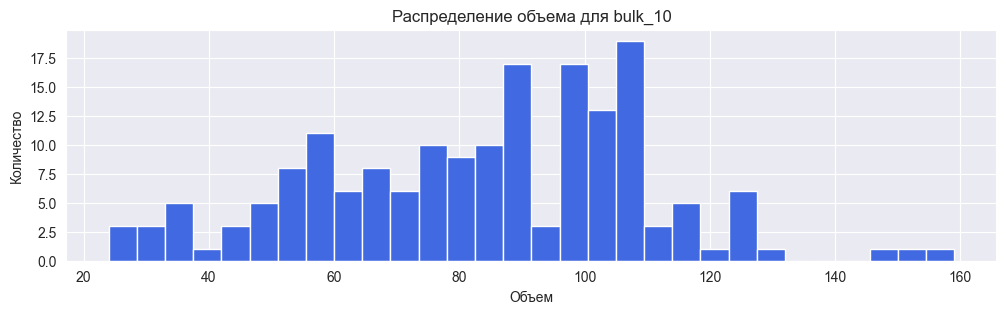

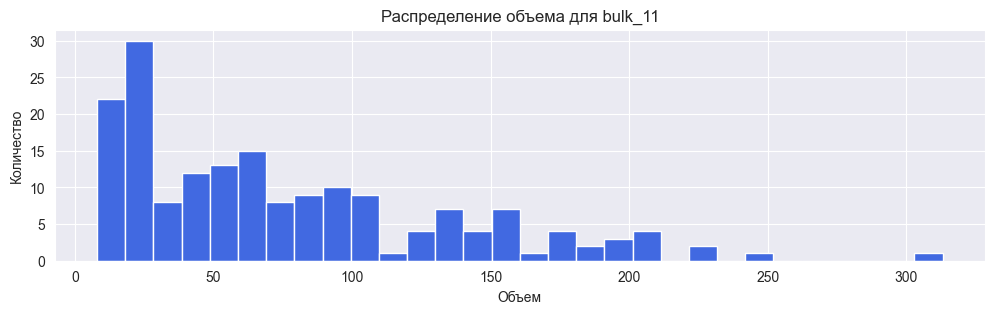

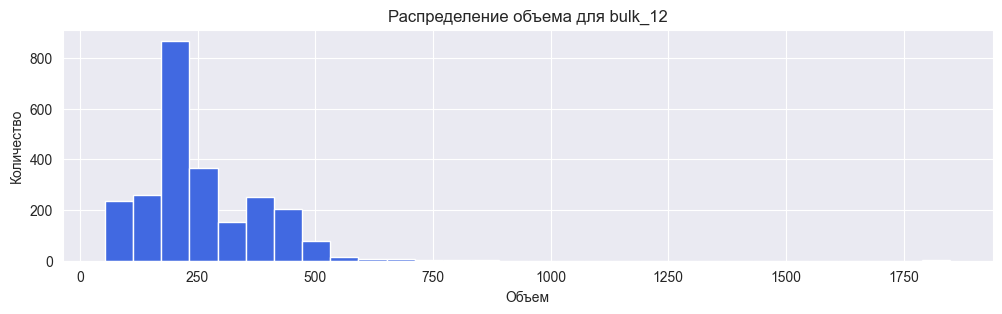

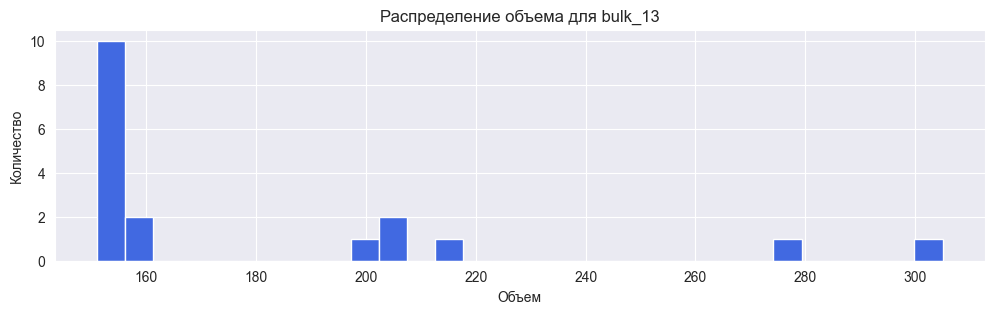

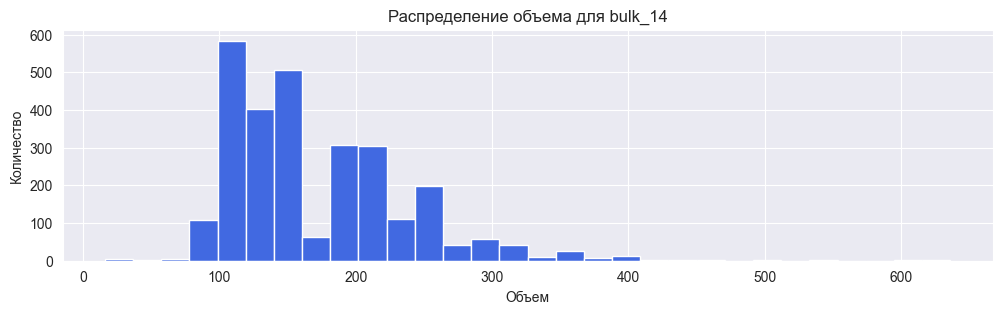

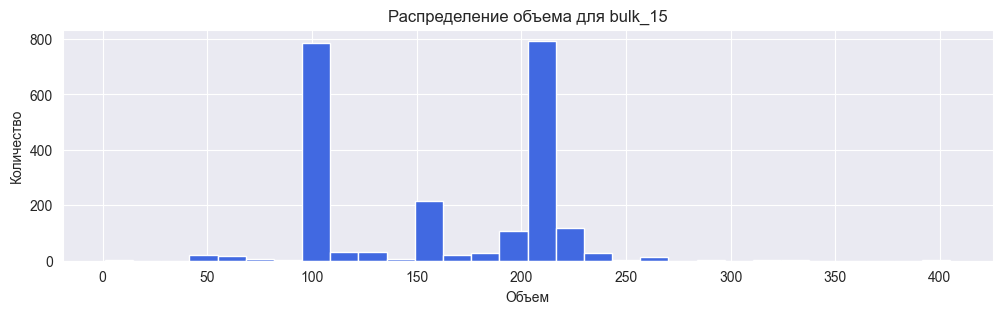

In [32]:
for column in bulk_columns:
    plt.figure(figsize=(12, 3))
    data_bulk[column].hist(bins=30, color='royalblue')
    plt.title(f'Распределение объема для {column}')
    plt.xlabel('Объем')
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

У `bulk_8` одно значение на весь датасет. Выглядит немного странно. Возможно это очень дорогой материал, а может просто экспериментальный. Для модели машинного обучения одна запись вряд ли будет репрезентативна.

У нескольких материалов есть "хвосты", как мы уже заметили ранее. Они не выглядят аномально или странно, так что не будем их трогать.

**3. Heatmap корреляции материалов**

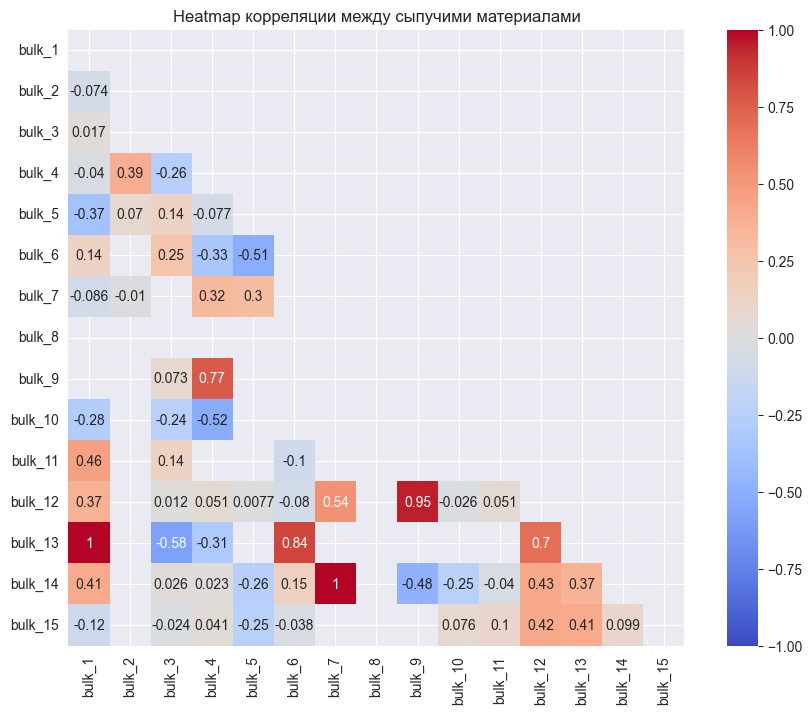

In [33]:
matrix = np.triu(data_bulk[bulk_columns].corr())
correlation = data_bulk[bulk_columns].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(correlation, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            mask=matrix, 
            square=True)
plt.title('Heatmap корреляции между сыпучими материалами');

Заметны несколько сильно выделяющихся линейных зависимостей между:
- `bulk_1` и `bulk_13` = 1
- `bulk_7` и `bulk_14` = 1
- `bulk_9` и `bulk_12` = 0.95
- `bulk_6` и `bulk_13` = 0.84

Высокая корреляция между двумя признаками может иметь естественное объяснение - например, если два разных сыпучих материала всегда добавляются в сплав в строго определенных пропорциях, то их объёмы будут высоко коррелировать. Однако стоит учитывать тот факт, что если мы будем использовать линейные модели, то высокая корреляция признаков может привести к проблемам мультиколлинеарности.

Стоит уточнить у заказчика этот момент.

<h4>Вывод

- Нет дубликатов
- Есть пропуски. Скорее всего это простое отсутствие засыпки материала на определенной итерации
- У `bulk_8` одно значение, стоит узнать о его необходимости в дальнейшей работе. Возможно его использование было экспериментальным
- Есть очевидные линейные зависимости между некоторыми материалами
- У `bulk_12` есть аномально высокое значение
- Нет отрицательных значений или отрицательных выбросов 

---
<h3>Данные о подаче сыпучих материалов (время)

Изучим типы данных.

In [34]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


Приведем все столбцы (кроме `key`) к типу данных `datetime`.

In [35]:
for column in data_bulk_time.columns[1:]:
    data_bulk_time[column] = pd.to_datetime(data_bulk_time[column], 
                                            format='%Y-%m-%d %H:%M:%S')

Изучим данные.

In [36]:
explore_data(data_bulk_time, 'data_bulk_time')

----------------------------------------

Исследование данных для data_bulk_time



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 17:26:33,2019-09-06 17:23:15



----- Общая информация -----

Размерность датасета:(3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[

None


----- Статистические характеристики -----



,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



----- Количество дубликатов -----

0

----- Количество пропусков -----

bulk_8     3128
bulk_13    3111
bulk_9     3110
bulk_2     3107
bulk_7     3104
bulk_5     3052
bulk_10    2953
bulk_11    2952
bulk_1     2877
bulk_6     2553
bulk_4     2115
bulk_3     1831
bulk_15     881
bulk_12     679
bulk_14     323
key           0
dtype: int64




Дубликатов нет, а пропуски соответстввуют пропускам в датасете с объемом материалов.

Построим графики.

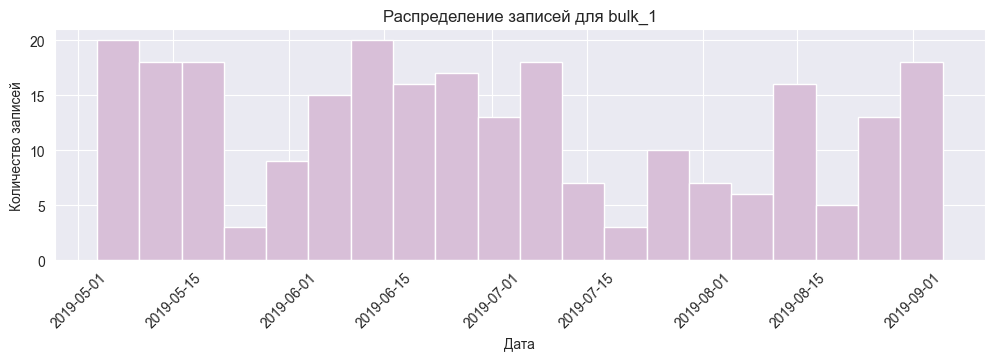

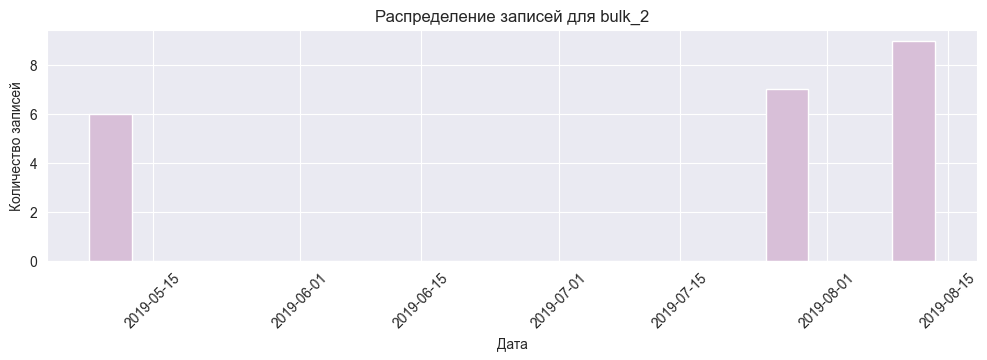

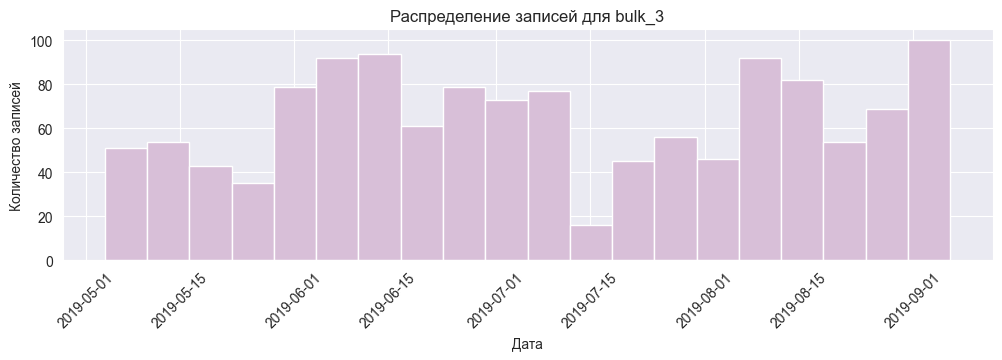

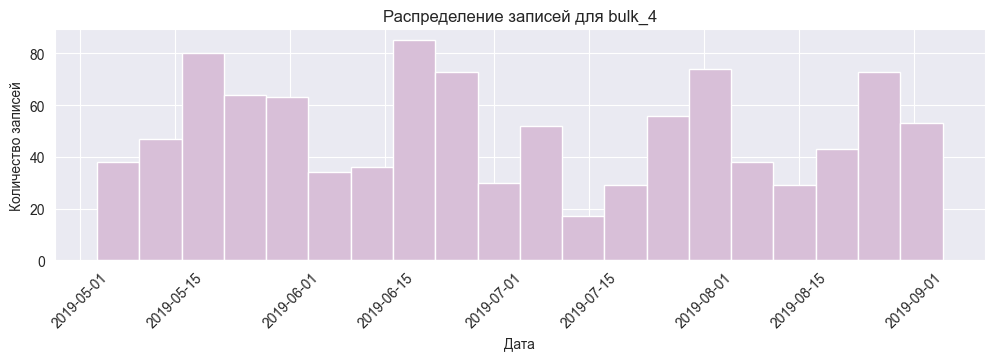

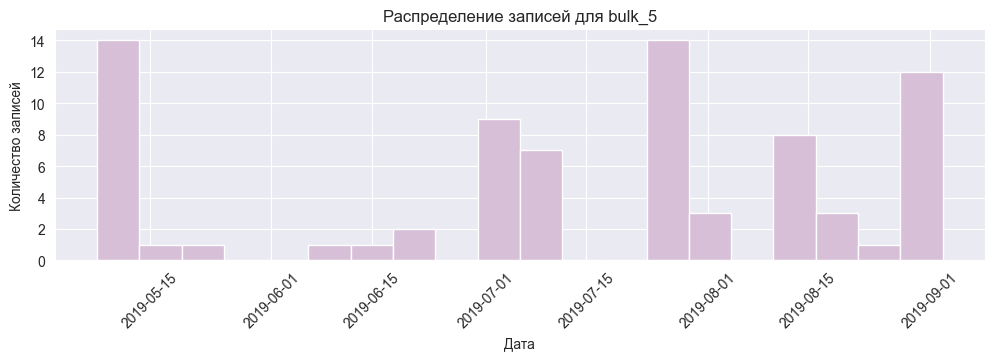

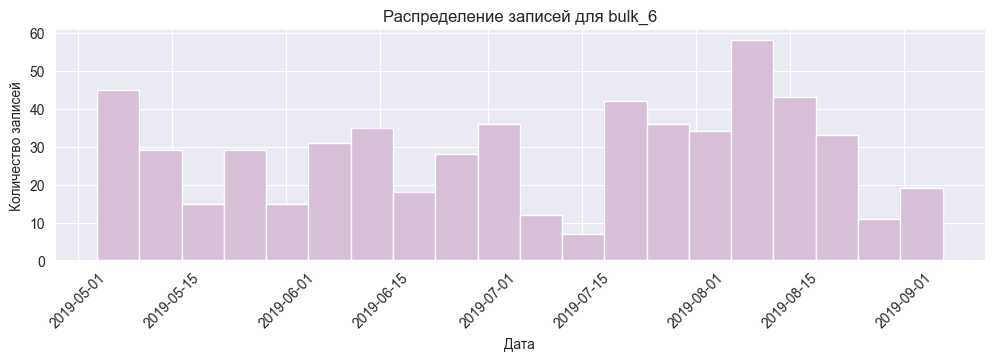

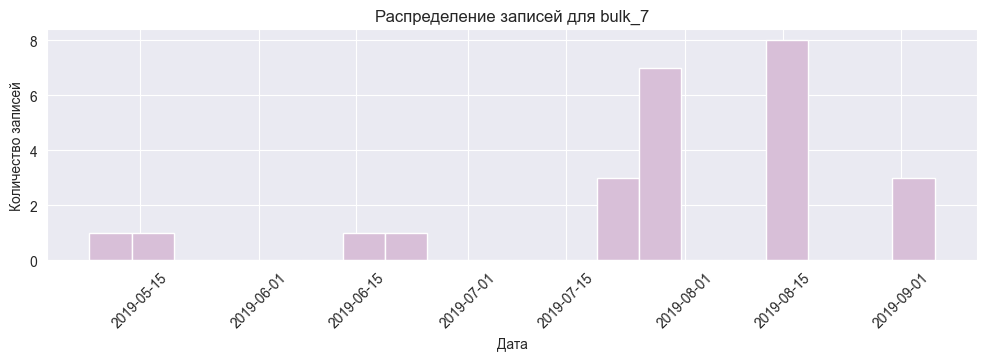

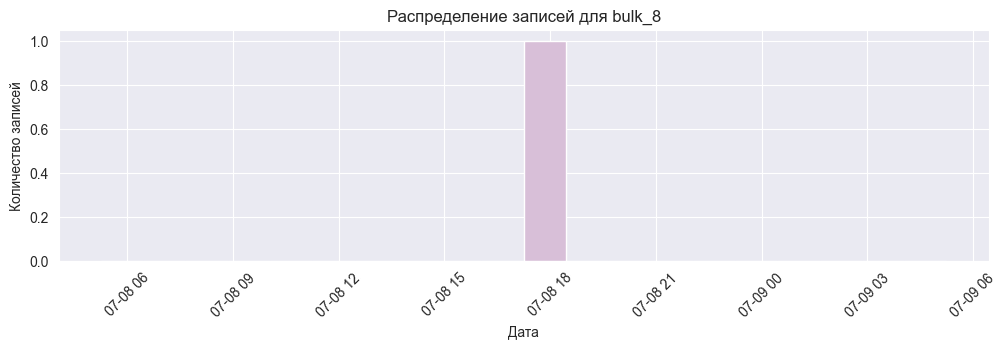

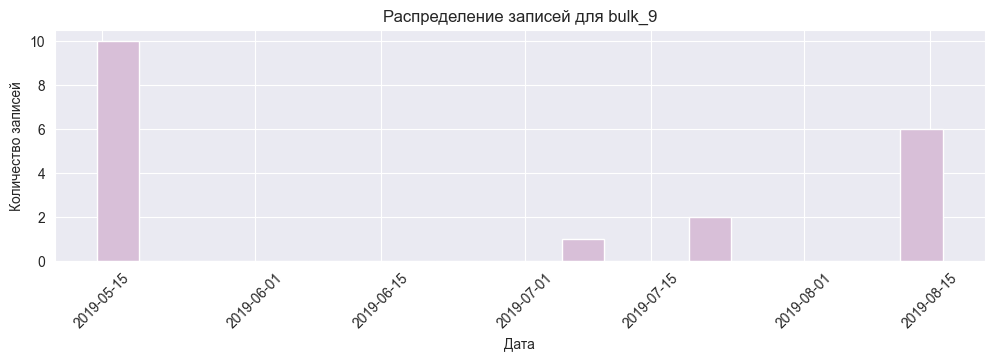

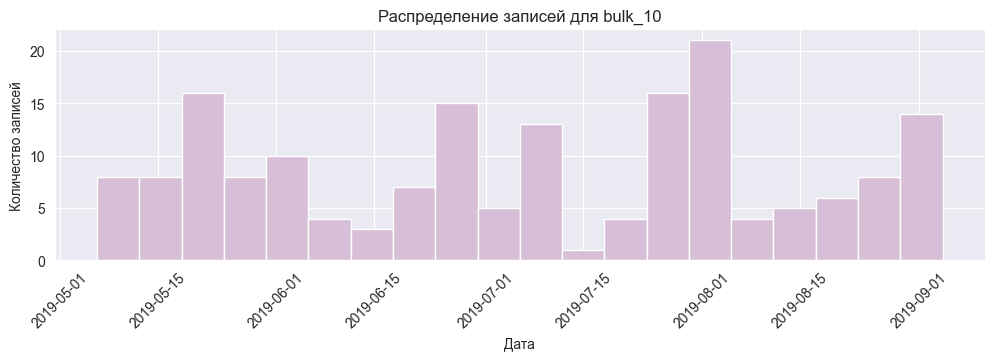

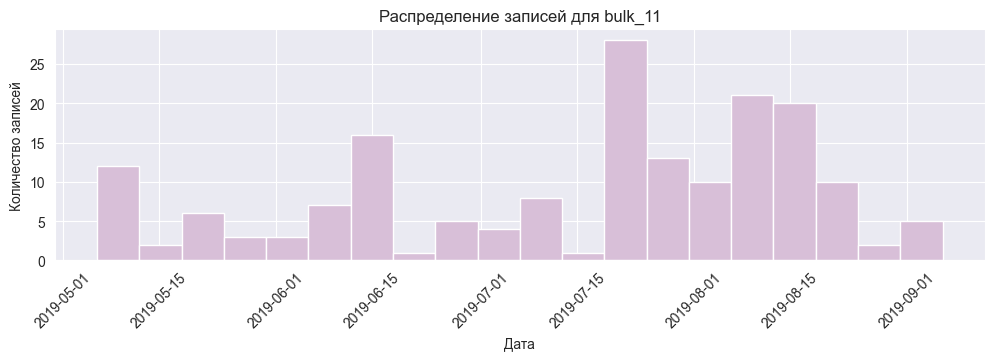

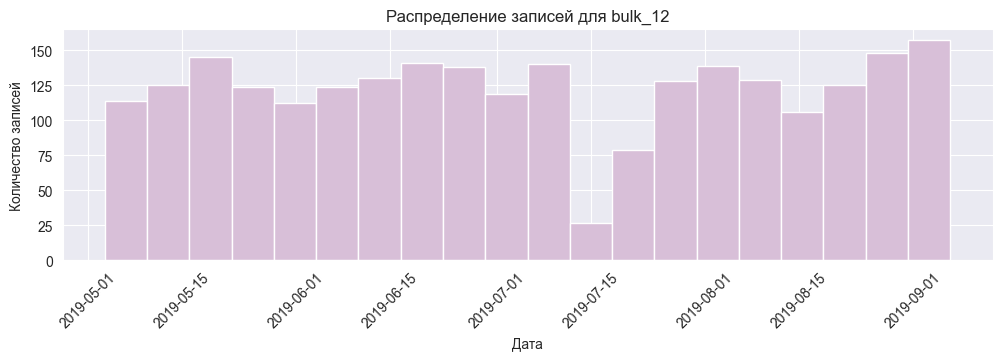

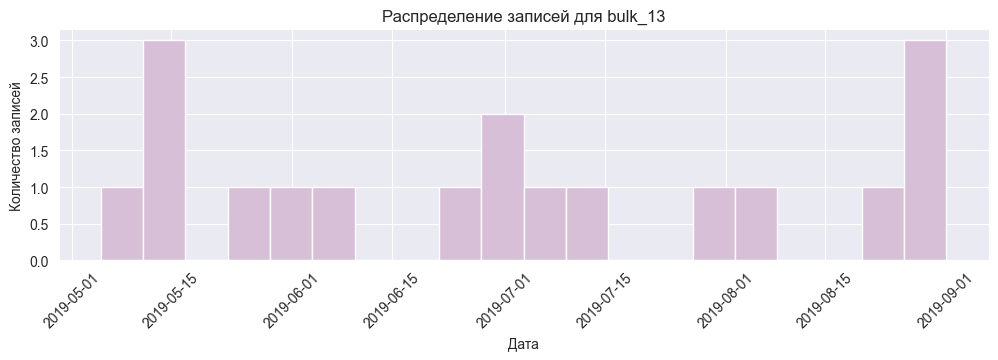

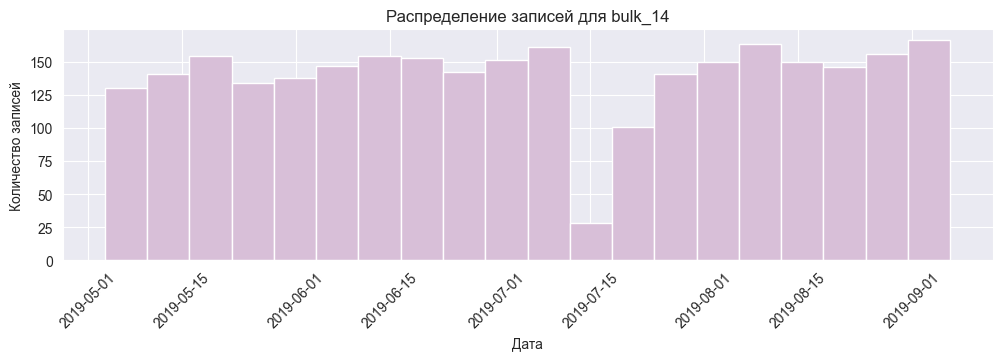

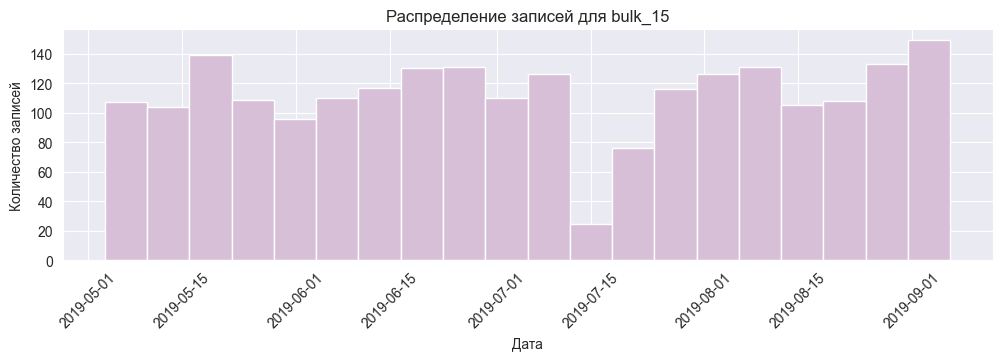

In [37]:
for column in data_bulk_time.columns[1:]:
    plt.figure(figsize=(12, 3))
    plt.hist(data_bulk_time[column], color='thistle', bins=20)
    plt.title(f'Распределение записей для {column}')
    plt.xlabel('Дата')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

<h4>Вывод

- Время записано в формате object
- Есть пропуски. Они совпадают с пропусками в датасете объема сыпучих материалов 
- Представлены данные с `2019-05-03` по `2019-09-06`
- `bulk_2`, `bulk_5`, `bulk_7`, `bulk_8`, `bulk_9` и `bulk_13` используют реже всех остальных материалов - ни за один период они не набирают более 15-ти записей. Стоит узнать у заказчика, сильно ли они важны для цели проекта

---
<h3>Данные о продувке сплава газом

Изучим данные.

In [38]:
explore_data(data_gas, 'data_gas')

----------------------------------------

Исследование данных для data_gas



,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,газ_1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959



----- Общая информация -----

Размерность датасета:(3239, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None


----- Статистические характеристики -----



,key,газ_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



----- Количество дубликатов -----

0

----- Количество пропусков -----

key      0
газ_1    0
dtype: int64




Дубликатов нет, пропусков нет. Статистические данные выглядят нормально.

Построим графики.

**KDE и Boxplot для газа**

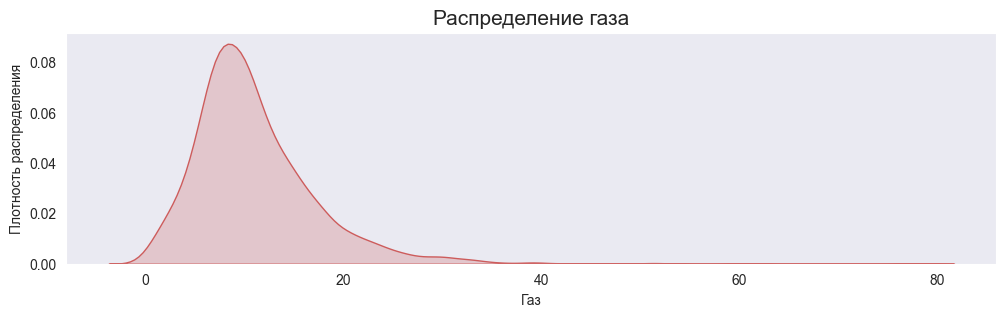

In [39]:
plt.figure(figsize=(12, 3))
sns.kdeplot(data_gas['газ_1'], color='indianred', legend=True, fill=True)
plt.xlabel('Газ')
plt.ylabel('Плотность распределения')
plt.title('Распределение газа', fontsize=15)
plt.grid();

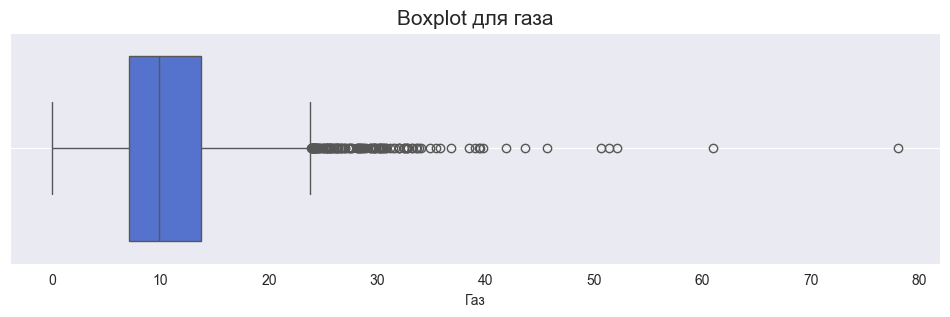

In [40]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=data_gas['газ_1'], orient='h', color='royalblue')
plt.xlabel('Газ')
plt.title('Boxplot для газа', fontsize=15)
plt.grid()

<h4>Вывод

- Дубликатов нет
- Пропусков нет
- Есть небольшой "хвост"
- Присутствуют несколько больших значений, но они не выглядят как выброс

---
<h3>Результаты измерения температуры

Изучим типы данных.

In [41]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   время_замера  18092 non-null  object 
 2   температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Приведем столбец тип данных столбца`время_замера` к `datetime`.

In [42]:
data_temp['время_замера'] = pd.to_datetime(data_temp['время_замера'], 
                                           format='%Y-%m-%d %H:%M:%S')

Изучим данные.

In [43]:
explore_data(data_temp, 'data_temp')

----------------------------------------

Исследование данных для data_temp



,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,время_замера,температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN



----- Общая информация -----

Размерность датасета:(18092, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None


----- Статистические характеристики -----



,key,время_замера,температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381



----- Количество дубликатов -----

0

----- Количество пропусков -----

температура     3427
key                0
время_замера       0
dtype: int64




Дубликатов нет. Есть пропуски в значениях температуры.

Построим графики

**1. KDE и Boxplot температуры**

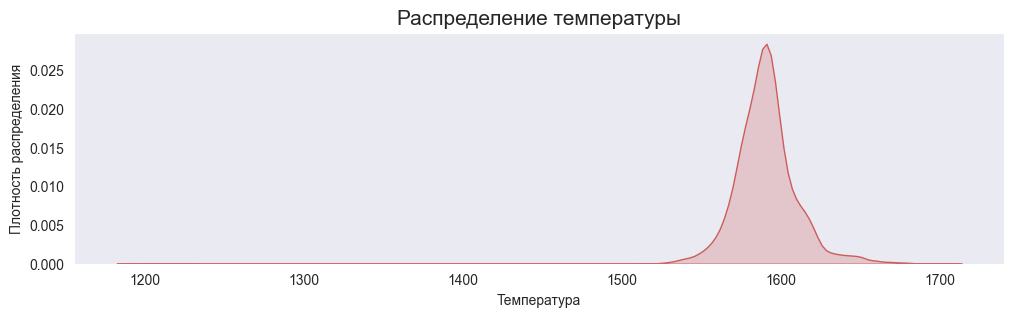

In [44]:
plt.figure(figsize=(12, 3))
sns.kdeplot(data_temp['температура'], color='indianred', legend=True, fill=True)
plt.xlabel('Температура')
plt.ylabel('Плотность распределения')
plt.title('Распределение температуры', fontsize=15)
plt.grid();

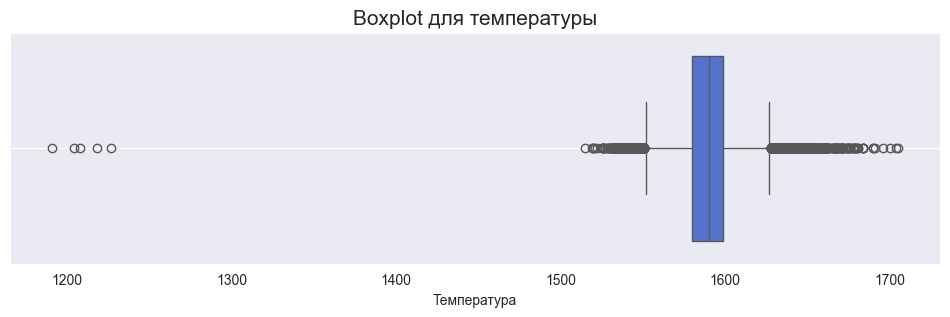

In [45]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=data_temp['температура'], orient='h', color='royalblue')
plt.xlabel('Температура')
plt.title('Boxplot для температуры', fontsize=15)
plt.grid()

Данные выглядят неплохо. Однако хвост в районе значений 1200-1500 выглядит странно. Стоит уточнить у заказчика, какое допустимое отклонение температуры.

**2. Динамика температуры во времени**

Text(0, 0.5, 'Температура')

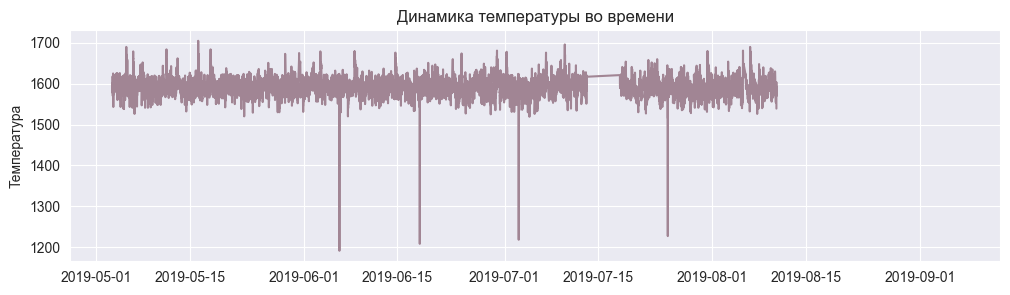

In [46]:
plt.figure(figsize=(12, 3))
plt.plot(data_temp['время_замера'], data_temp['температура'], label='Температура', color='#A18594')
plt.title('Динамика температуры во времени')
plt.ylabel('Температура')

Видны эти низкие значения температуры. Также заметен период без записей. Взглянем на него поближе.

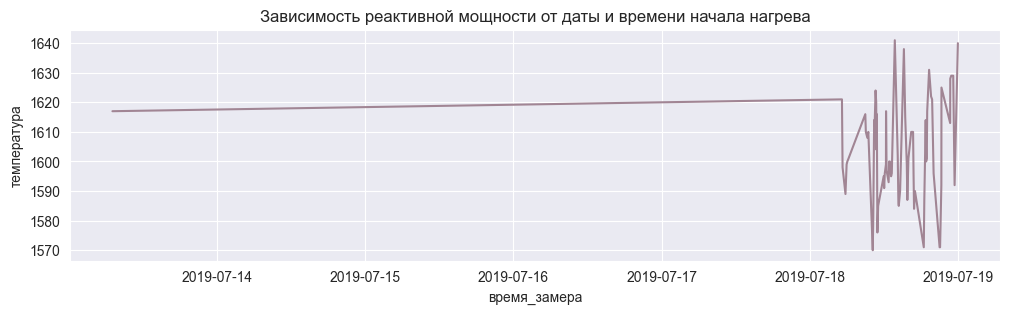

In [47]:
filtered_data = data_temp[(data_temp['время_замера'] >= '2019-07-13 07') 
                         & (data_temp['время_замера'] <= '2019-07-19')]

plt.figure(figsize=(12, 3))
sns.lineplot(x=filtered_data['время_замера'], 
             y=filtered_data['температура'], 
             color='#A18594')
plt.title('Зависимость реактивной мощности от даты и времени начала нагрева');

In [48]:
filtered_data.head()

,key,время_замера,температура
10617,1899,2019-07-13 07:03:34,1617.0
10618,1900,2019-07-18 05:11:50,1621.0
10619,1900,2019-07-18 05:17:48,1598.0
10620,1900,2019-07-18 05:46:00,1589.0
10621,1900,2019-07-18 05:57:12,1599.0


Также, как и в данных об электродах - записи с 13 по 18 июля отсутствуют.

<h4>Вывод

- Дубликатов нет
- Есть пропуски в значениях температуры
- Есть небольшой хвост в столбце температуры
- Отсутствуют записи с утра 13 июля до утра 18 июля 2019 года

---
<h3>Данные о проволочных материалах (объём)

Изучим данные.

In [49]:
explore_data(data_wire, 'data_wire')

----------------------------------------

Исследование данных для data_wire



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



----- Общая информация -----

Размерность датасета:(3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None


----- Статистические характеристики -----



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



----- Количество дубликатов -----

0

----- Количество пропусков -----

wire_5    3080
wire_7    3070
wire_4    3067
wire_8    3062
wire_9    3052
wire_3    3018
wire_6    3008
wire_2    2002
wire_1      26
key          0
dtype: int64




Дубликатов нет. Есть пропуски во всех столбцах (кроме `key`).

Построим графики.

In [50]:
# Не будем строить график для key
wire_columns = [col for col in data_wire.columns if "wire_" in col]

**1. Boxplot для всех материалов**

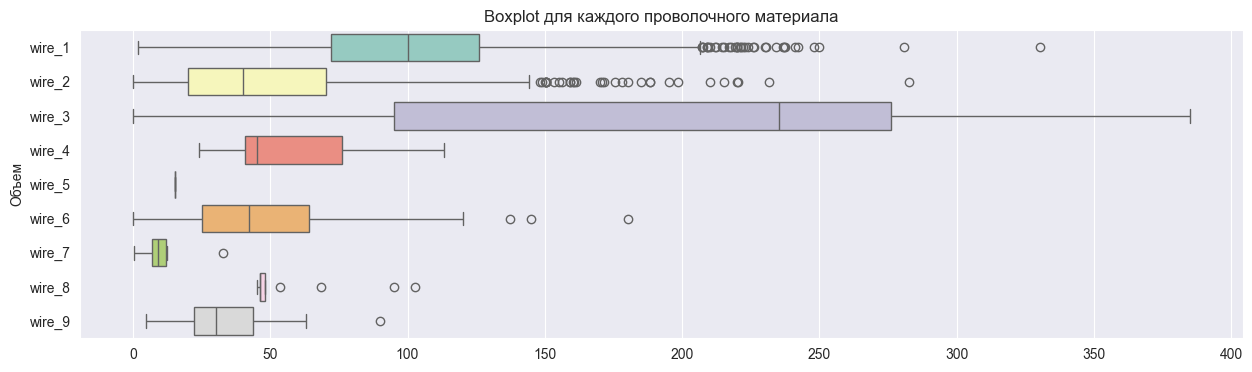

In [51]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=data_wire[wire_columns], orient='h', palette='Set3')
plt.title('Boxplot для каждого проволочного материала')
plt.ylabel('Объем')
plt.show()

**2. Распределение количества материала**

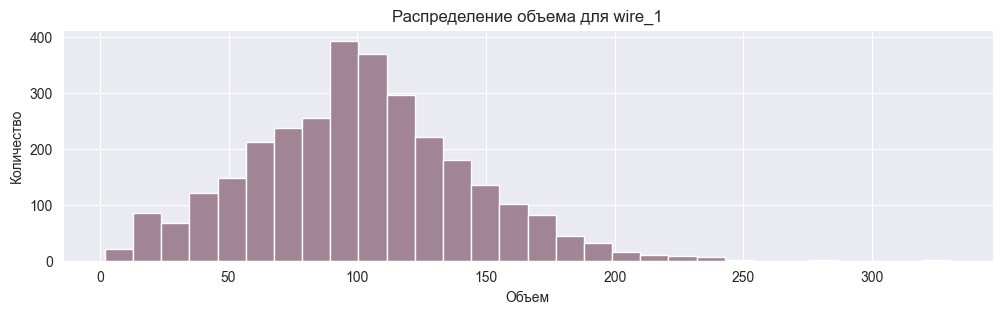

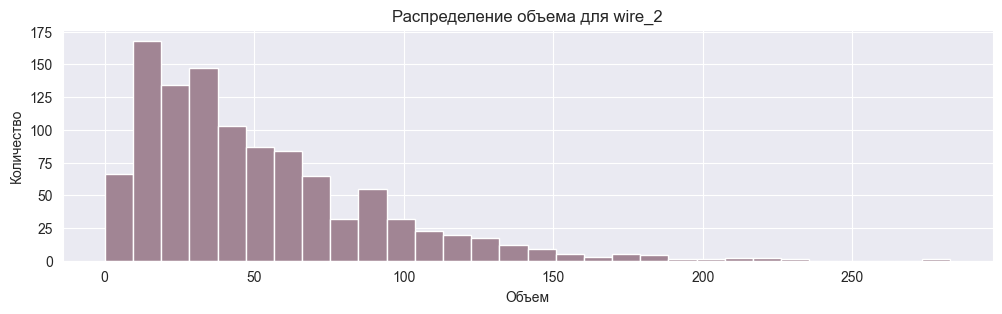

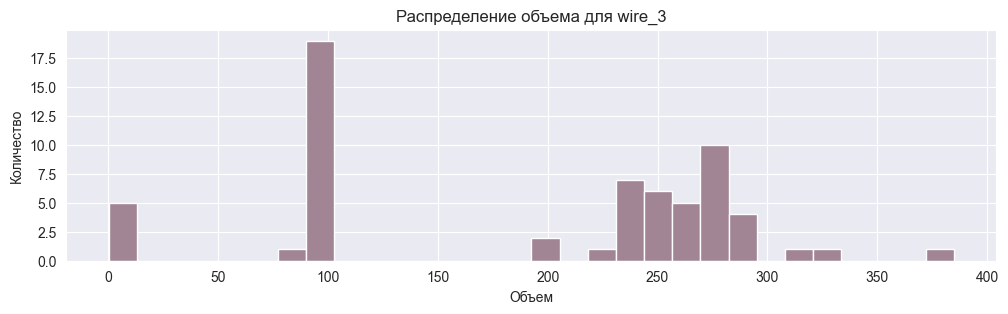

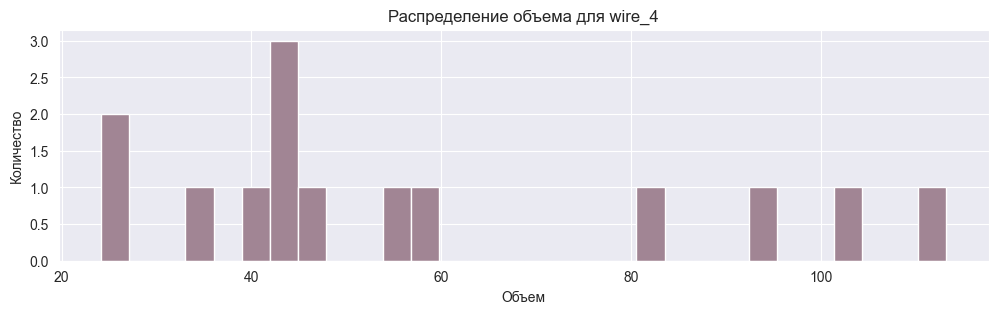

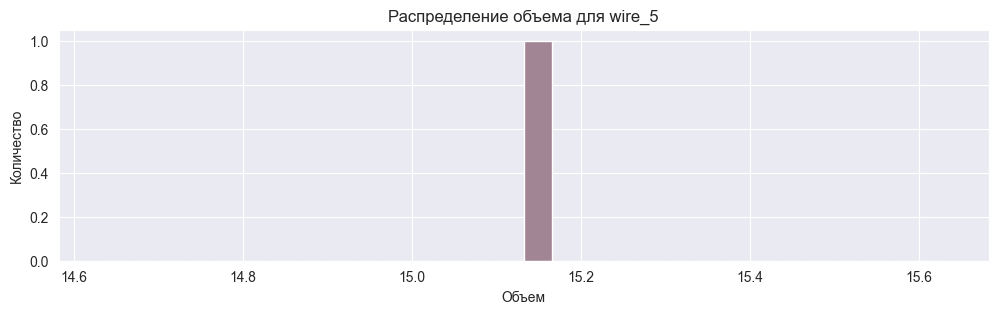

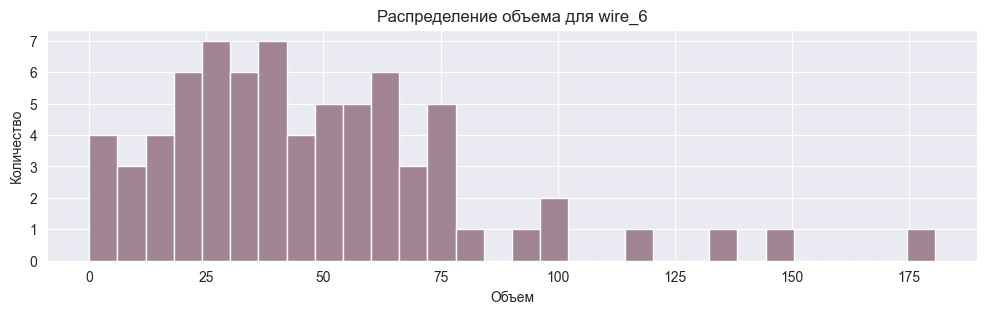

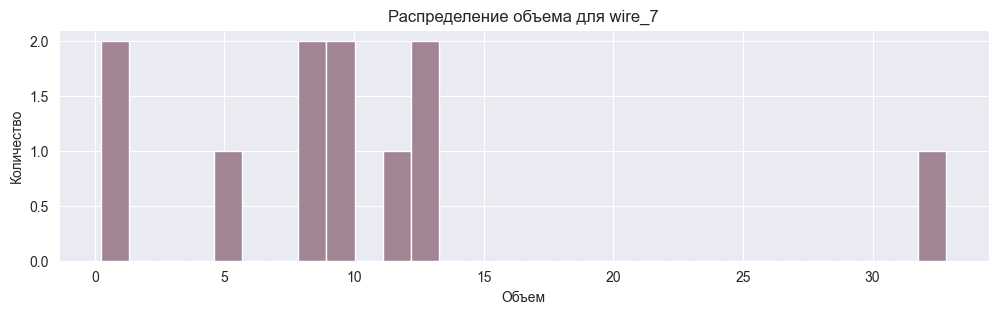

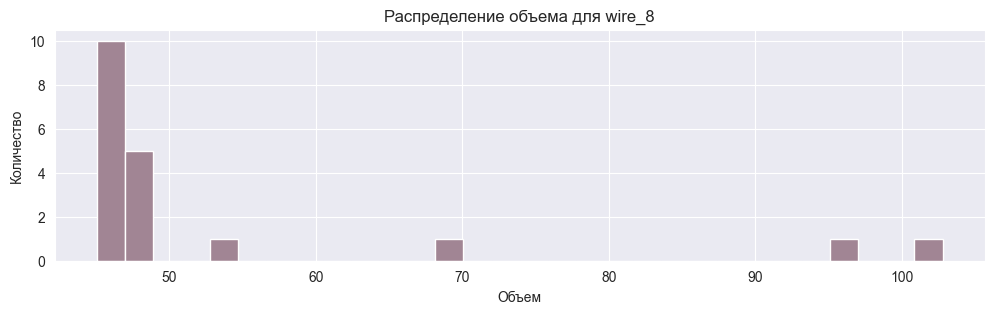

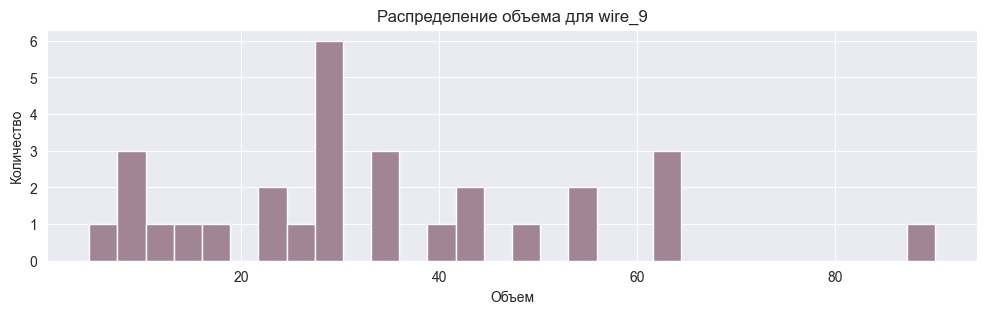

In [52]:
for column in wire_columns:
    plt.figure(figsize=(12, 3))
    data_wire[column].hist(bins=30, color='#A18594')
    plt.title(f'Распределение объема для {column}')
    plt.xlabel('Объем')
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

Судя по графикам, проволочные материалы используются совершенно в отличных от сыпучих материалов количествах. Только `wire_1` и `wire_2` добавляют в больших количествах, остальные же применяются в разы реже и меньше по объему. Как и с сыпучими материалами есть материал с одним использованием за все время - `wire_5`.

**3. Heatmap корреляции между материалами**

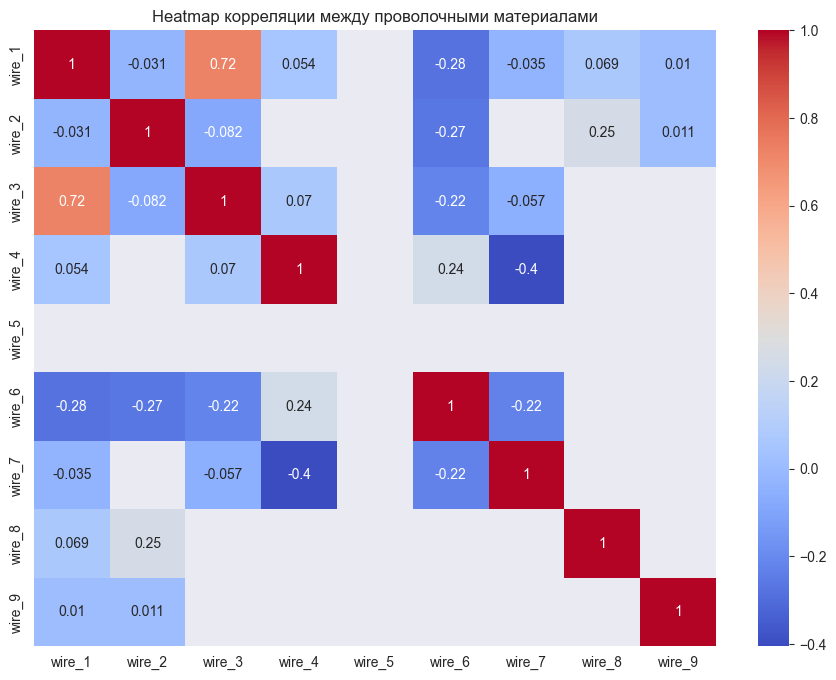

In [53]:
correlation = data_wire[wire_columns].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Heatmap корреляции между проволочными материалами')
plt.grid();

У большинства материалов видимо слишком мало записей, чтобы иметь хоть какую-то корреляцию с другими. Однако у `wire_1` и `wire_3` виднеется линейная зависимость.

<h4>Вывод

- Нет дубликатов
- Есть пропуски. Скорее всего, как и с сыпучими материалами, это связано с тем, что материал просто не подавался в той или иной итерации
- Очень мало записей почти у всех материалов, только `wire_1` и `wire_2` используются часто
- У `wire_5` одна запись
- у `wire_1` и `wire_3` высокая корреляция

---
<h3>Данные о проволочных материалах (время)

Взглянем на тип данных.

In [54]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Как и в датасете с временем сыпчих материалов, время предоставлено в виде типа данных `object`. Сменим его на тип данных `datetime`.

In [55]:
for column in data_wire_time.columns[1:]:
    data_wire_time[column] = pd.to_datetime(data_wire_time[column], 
                                            format='%Y-%m-%d %H:%M:%S')

Изучим данные.

In [56]:
explore_data(data_wire_time, 'data_wire_time')

----------------------------------------

Исследование данных для data_wire_time



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3080,3241,2019-09-06 17:10:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT



----- Общая информация -----

Размерность датасета:(3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None


----- Статистические характеристики -----



,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



----- Количество дубликатов -----

0

----- Количество пропусков -----

wire_5    3080
wire_7    3070
wire_4    3067
wire_8    3062
wire_9    3052
wire_3    3018
wire_6    3008
wire_2    2002
wire_1      26
key          0
dtype: int64




Нет дубликатов. Пропуски там же и в том же количестве, что и в датасете с объемом проволочных материалов.

Построим графики.

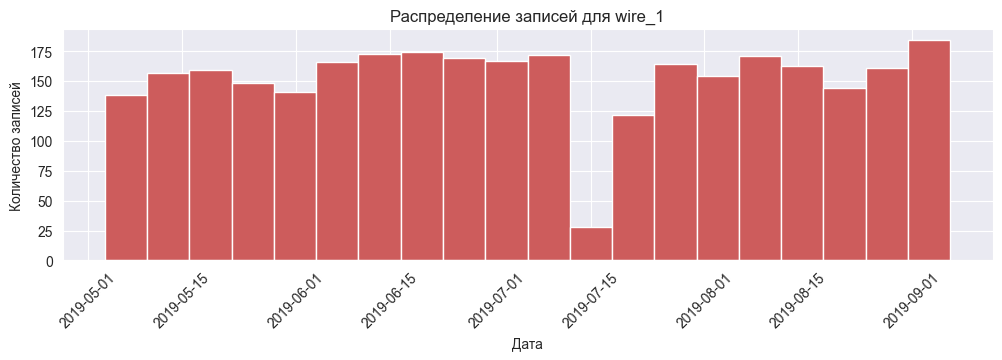

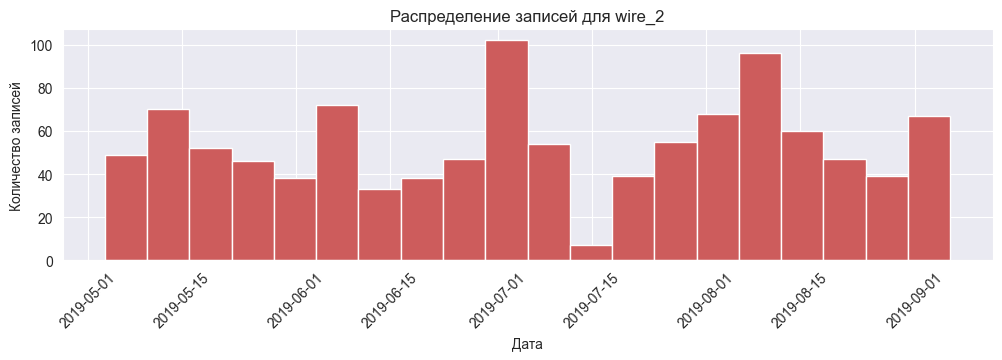

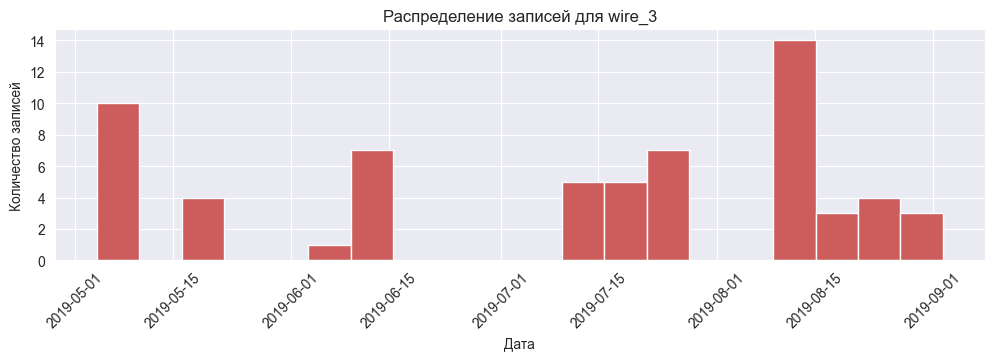

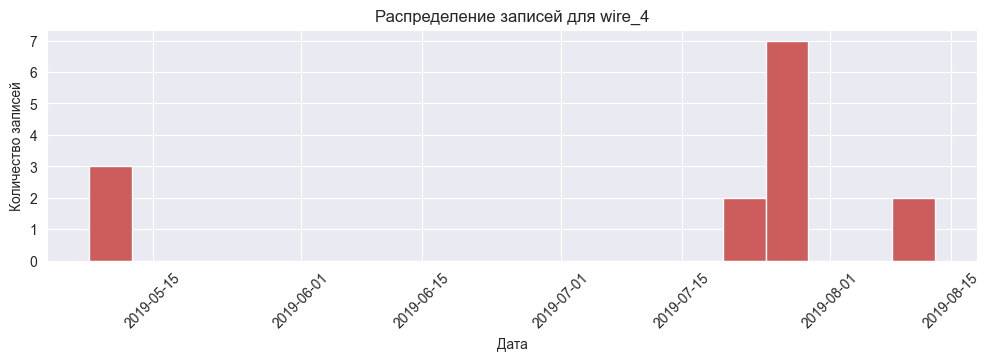

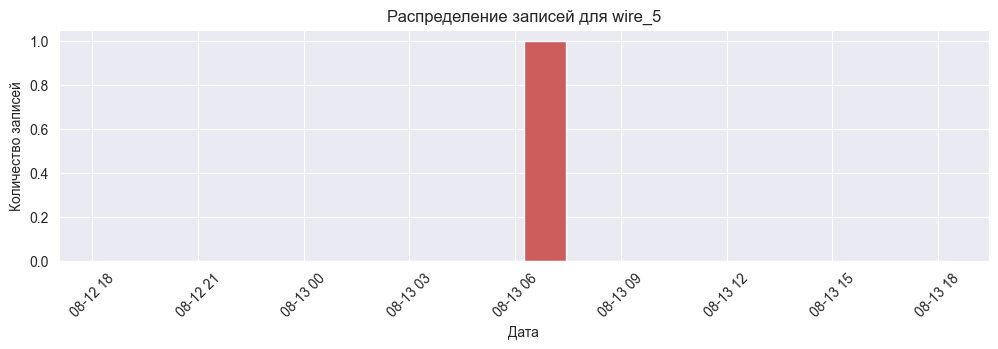

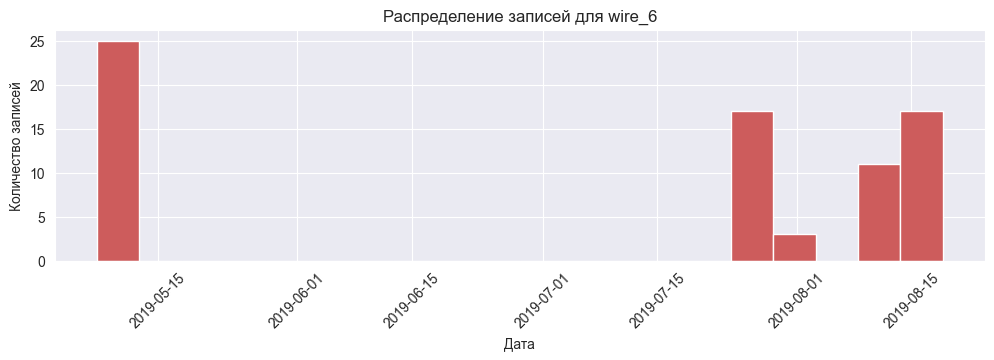

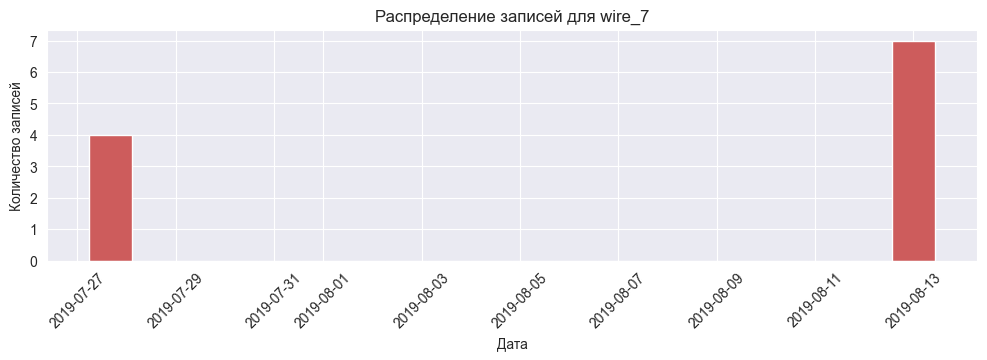

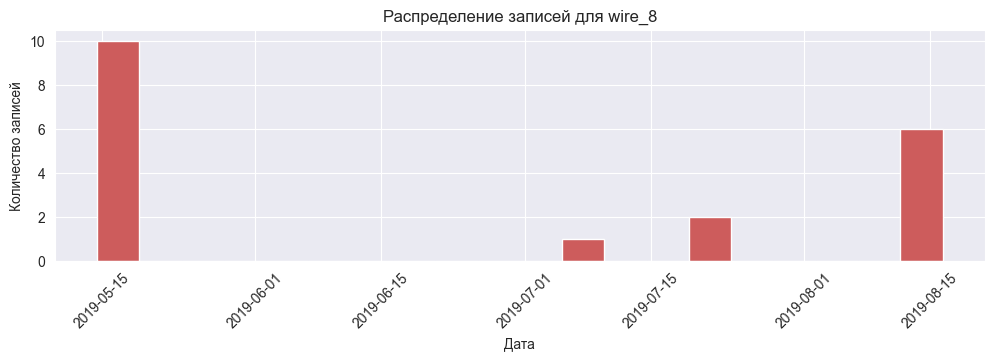

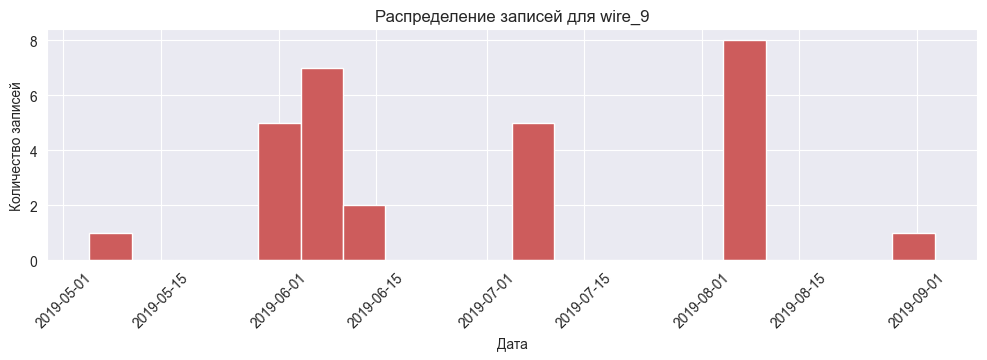

In [57]:
for column in data_wire_time.columns[1:]:
    plt.figure(figsize=(12, 3))
    plt.hist(data_wire_time[column], color='indianred', bins=20)
    plt.title(f'Распределение записей для {column}')
    plt.xlabel('Дата')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

<h4>Вывод

- Нет дубликатов
- Есть пропуски, совпадают с пропусками из датасета с объемами материалов
- Данные предоставлены с `2019-05-03` по `2019-09-06`

---
<h3>Общий вывод

**Наблюдения:**

- Количество уникальных значений партии - `key` - в каждом датасете разное

- Даты во всех датасетах имеют формат `object`

- Временной промежуток предоставленных данных - с `2019-05-03` по `2019-09-06`

- Ни в одном датасете не было найдено дубликатов

- Пропуски в датасетах `data_bulk`, `data_bulk_time`, `data_wire`, `data_wire_time`, `data_temp`

- В реактивной мощности есть отрицательный выброс

- В данных о температуре есть "хвост"

- В каждом датасете отсутствуют данные на период с `13 по 18 июля 2019 года`

- Есть признаки с высокой корреляцией

---

<a id='3'></a>

<h2><a id="chapter3"></a>Предобработка данных</h2>

<h3><a id="chapter3.1"></a>Удаление выбросов</h3>

В исследовательском анализе мы уже создавали датасет без отрицательного выброса. Просто перезапишем нашу переменную с изначальным датасетом.

In [58]:
data_arc = data_arc_copy

Проверим минимальное значение реактивной мощности.

In [59]:
data_arc['реактивная_мощность'].describe()

count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

Всё хорошо, от выброса избавились.

Теперь обработаем аномальные значения в температуре. За минимальный порог возьмем значения от 1400. Удалим записи по ключам, в которых встречаются выбросы.

In [60]:
key = data_temp.query('температура <= 1400')['key'].unique()
data_temp = data_temp.query('key not in @key').reset_index(drop=True)

Проверим минимальное значение.

In [61]:
data_temp['температура'].describe()

count    14643.000000
mean      1590.865055
std         19.122102
min       1519.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: температура, dtype: float64

Все хорошо, от выбросов избавились.

<h3><a id="chapter3.2"></a>Обработка пропусков</h3>

Как мы поняли из исследовательского анализа, в датасетах с объемами материалов пропуски указывают на то, что материал не засыпался в указанный ковш. Заменим все `Nan` значения нулями.

In [62]:
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

In [63]:
display(data_bulk.head(), data_wire.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3><a id="chapter3.3"></a>Обработка признаков</h3>

Для лучшей работы модели создадим дополнительные признаки, основанные на имеющихся данных, а также удалим ненужные.

**ЭНЕРГИЯ**

In [64]:
data_arc['длительность_нагрева_сек'] = (
    data_arc['конец_нагрева_дугой'] - data_arc['начало_нагрева_дугой']
).dt.total_seconds()

data_arc['энергия'] = data_arc['длительность_нагрева_сек'] * data_arc['активная_мощность']

energy = data_arc.groupby('key')['энергия'].sum().reset_index()

energy = energy.sort_values(by='key')

display(energy.head())

,key,энергия
0,1,628.616930
1,2,395.281800
2,3,581.774624
3,4,543.710274
4,5,412.180480


**ПОЛНАЯ МОЩНОСТЬ**

In [65]:
data_arc['полная_мощность'] = (
    data_arc['активная_мощность']**2 + data_arc['реактивная_мощность']**2
)**0.5

total_power = data_arc.groupby('key')['полная_мощность'].sum().reset_index()

total_power = total_power.sort_values(by='key')

display(total_power.head())

,key,полная_мощность
0,1,3.718736
1,2,2.588349
2,3,5.019223
3,4,3.400038
4,5,2.816980


**НАЧАЛЬНАЯ И КОНЕЧНАЯ ТЕМПЕРАТУРЫ**

In [66]:
# Получение ключей, у которых есть пропуски в температуре
keys_with_na = data_temp[data_temp['температура'].isna()]['key'].unique()

# Удаление всех записей по этим ключам
data_temp_filtered = data_temp[~data_temp['key'].isin(keys_with_na)]

# Группировка по ключу и создание нового DataFrame
grouped = data_temp_filtered.groupby('key')['температура']

df_temp = pd.DataFrame({
    'начальная_температура': grouped.first(),
    'конечная_температура': grouped.last()
}).reset_index()

In [67]:
df_temp

,key,начальная_температура,конечная_температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2468,2495,1570.0,1591.0
2469,2496,1554.0,1591.0
2470,2497,1571.0,1589.0
2471,2498,1591.0,1594.0


**ВРЕМЯ ЗАМЕРА**

In [68]:
grouped_time = data_temp_filtered.groupby('key')['время_замера']

time_deltas = (grouped_time.last() - grouped_time.first()).dt.total_seconds()

df_temp['время_между_замерами'] = time_deltas.values

**УДАЛЕНИЕ РЕДКИХ МАТЕРИАЛОВ**

В таблицах имеются данные по материалам, которые засыпали очень редко(менее 30 раз). Удалим им их, так как для модели машинного обучения они будут нерепрезентативны.

In [69]:
columns_to_remove = ['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13']
data_bulk = data_bulk.drop(columns_to_remove, axis=1)

In [70]:
columns_to_remove = ['wire_4', 'wire_5', 'wire_7', 'wire_8']
data_wire = data_wire.drop(columns_to_remove, axis=1)

<h3><a id="chapter3.4"></a>Объединение таблиц</h3>

Объединим датасеты по ключу с помощью внутреннего объединения, который возвращает только те строки, для которых есть соответствующие значения в обоих таблицах, объединяемых по заданному ключу.

In [71]:
data = df_temp.merge(right=total_power,
                       how='inner',
                       on='key')\
                .merge(right=data_bulk,
                       how='inner',
                       on='key')\
                .merge(right=data_wire,
                       how='inner',
                       on='key')\
                .merge(right=data_gas,
                       how='inner',
                       on='key')\
                .merge(right=energy,
                       how='inner',
                       on='key')

In [72]:
display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2324 non-null   int64  
 1   начальная_температура  2324 non-null   float64
 2   конечная_температура   2324 non-null   float64
 3   время_между_замерами   2324 non-null   float64
 4   полная_мощность        2324 non-null   float64
 5   bulk_1                 2324 non-null   float64
 6   bulk_3                 2324 non-null   float64
 7   bulk_4                 2324 non-null   float64
 8   bulk_5                 2324 non-null   float64
 9   bulk_6                 2324 non-null   float64
 10  bulk_10                2324 non-null   float64
 11  bulk_11                2324 non-null   float64
 12  bulk_12                2324 non-null   float64
 13  bulk_14                2324 non-null   float64
 14  bulk_15                2324 non-null   float64
 15  wire

None

,key,начальная_температура,конечная_температура,время_между_замерами,полная_мощность,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9,газ_1,энергия
0,1,1571.0,1613.0,1714.0,3.718736,0.0,0.0,43.0,0.0,0.0,...,206.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,29.749986,628.616930
1,2,1581.0,1602.0,1265.0,2.588349,0.0,0.0,73.0,0.0,0.0,...,206.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,12.555561,395.281800
2,3,1596.0,1599.0,1753.0,5.019223,0.0,0.0,34.0,0.0,0.0,...,205.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,28.554793,581.774624
3,4,1601.0,1625.0,1220.0,3.400038,0.0,0.0,81.0,0.0,0.0,...,207.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,18.841219,543.710274
4,5,1576.0,1602.0,1536.0,2.816980,0.0,0.0,78.0,0.0,0.0,...,203.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,5.413692,412.180480


Проверим признаки из полученного датасета на корреляцию.

Text(0.5, 1.0, 'Heatmap корреляции между признаками')

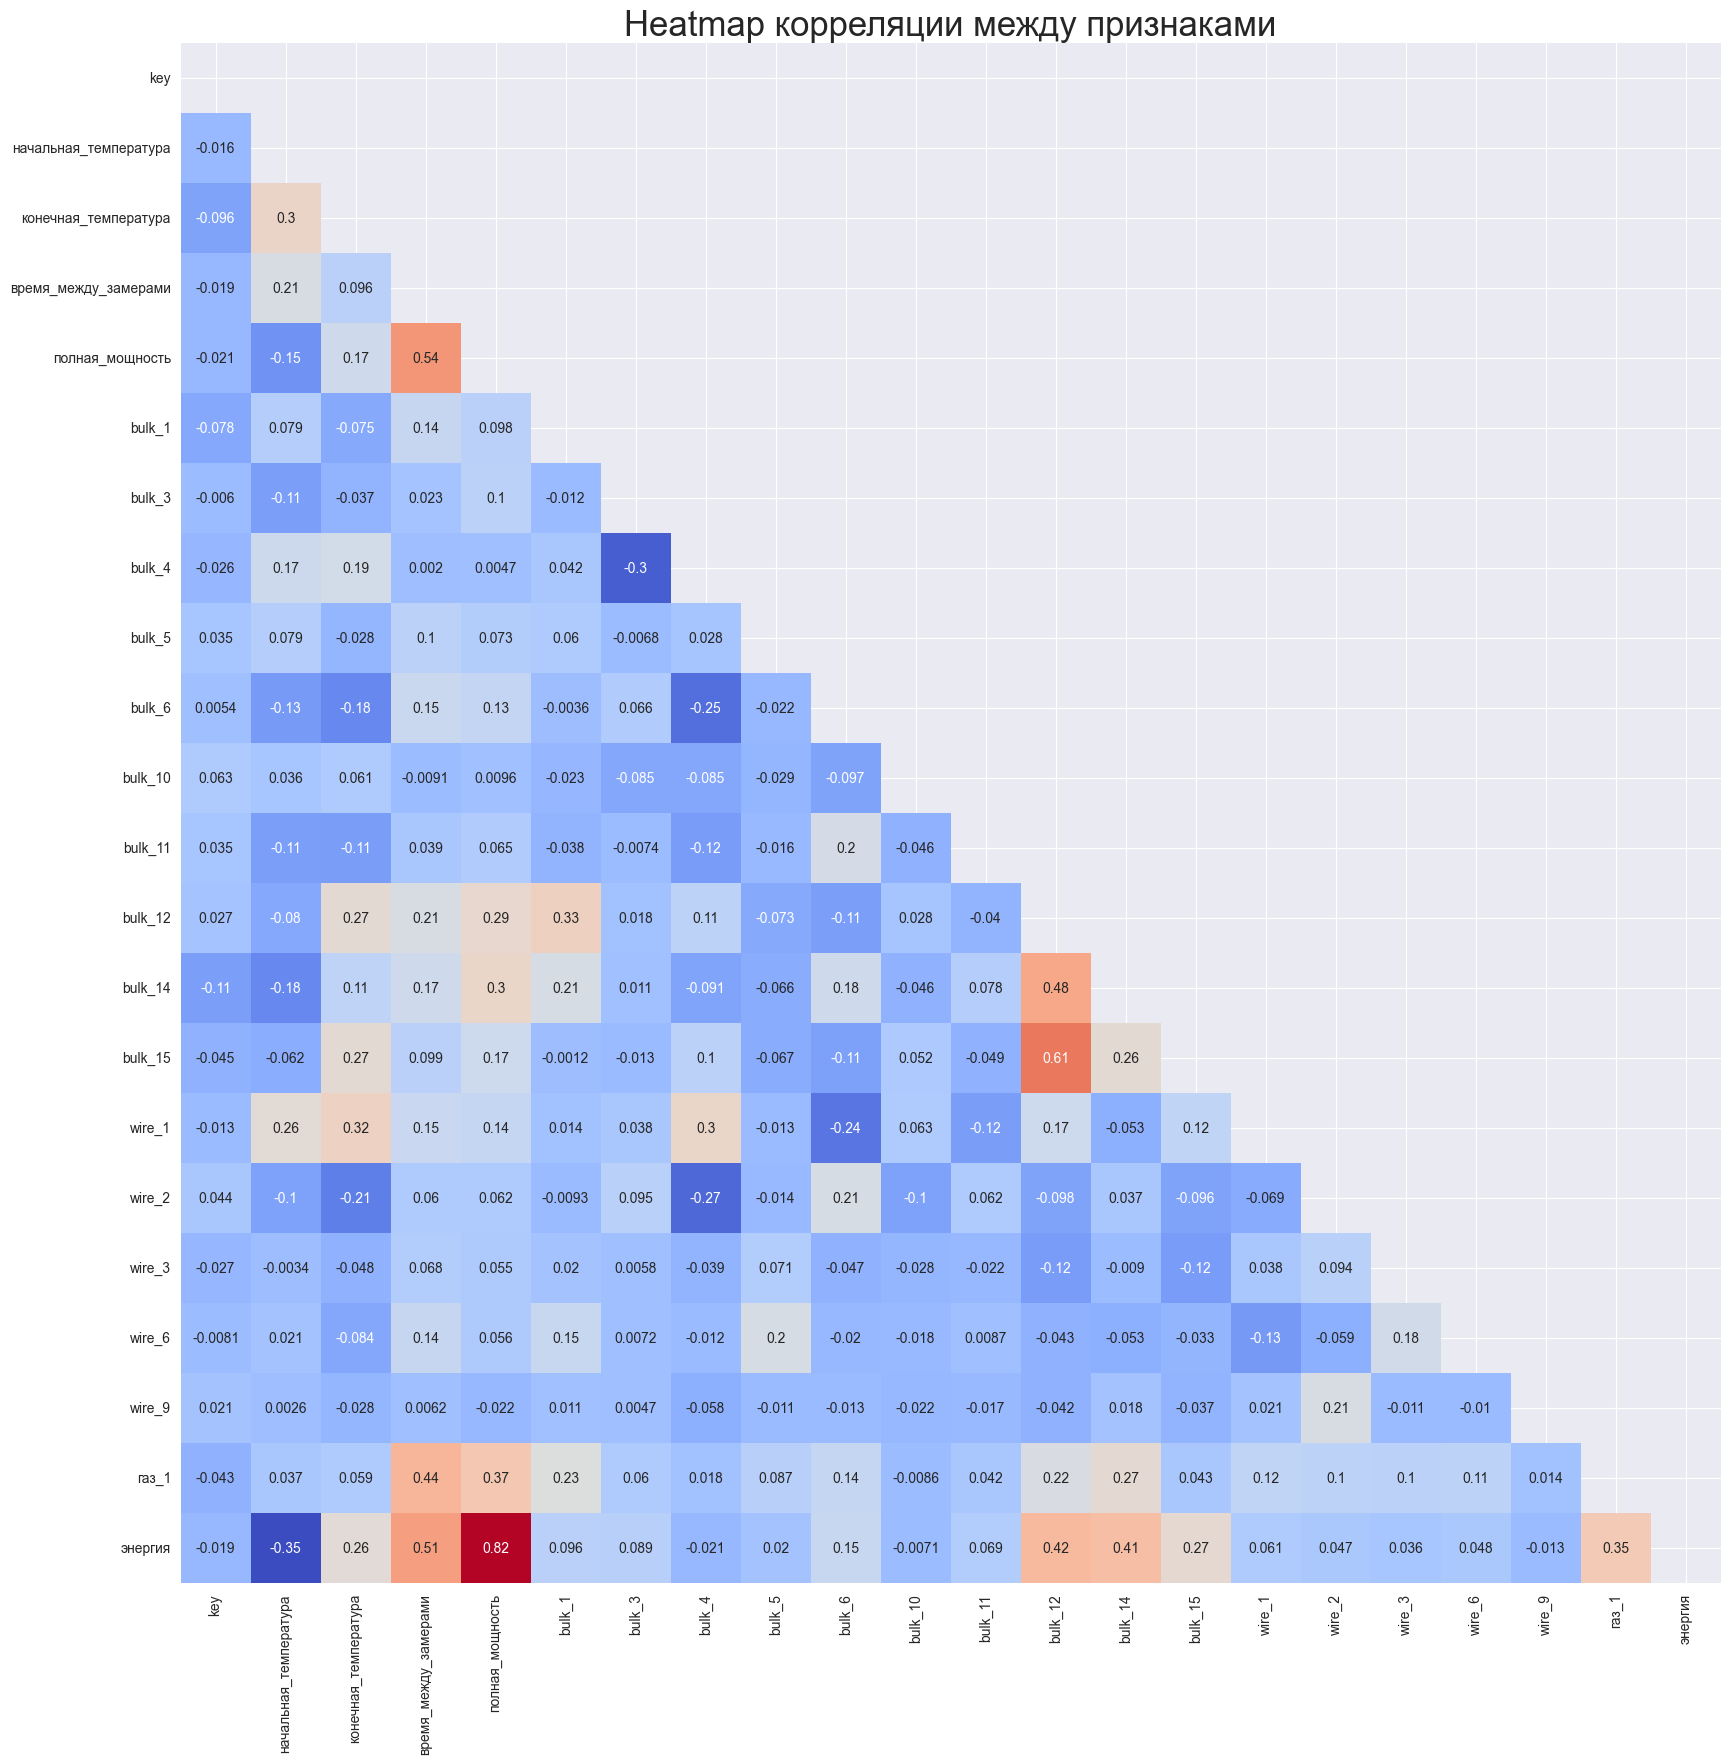

In [73]:
plt.figure(figsize=(20, 20))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(),
            annot=True,
            mask=matrix,
            square=True,
            cmap='coolwarm',
            cbar=False)
plt.title('Heatmap корреляции между признаками', fontsize=25)

Высокая линейная зависимость наблюдается между полной мощностью и энергией, что ожидаемо, так что не будем трогать эти признаки.

Есть также корреляция между `bulk_12` и `bukl_15`, но она не такая уж и высокая, так что оставляем.

<h3><a id="chapter3.5"></a>Общий вывод</h3>

В данном блоке проекта мы:

- Удалили выбросы
- Заменили пропуски в `data_bulk` и `data_wire` нулями
- Создали и удалили признаки для итоговой таблицы
- Объединили таблицы с помощью внутреннего объединения по `key`

---

<h2><a id="chapter4"></a>Подготовка к обучению</h2>

Подготовим данные для машинного обучения.

- Объявим две переменные:
  - Сохраним в `features` признаки
  - Сохраним в `target` целевой признак
- Разделим данные на тренировочную и тестовую выборки
- Применим StandardScaler

<h3><a id="chapter4.1"></a>Features и Target</h3>

Создадим переменные `features` и `target`.

In [74]:
features = data.drop(['конечная_температура', 'key'], axis=1)
target = data['конечная_температура']

Проверим их размерность.

In [75]:
features.shape, target.shape

((2324, 20), (2324,))

Разделим данные на обучающую и тестовую выборки в соотношении 75:25.

In [76]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=SEED)

Проверим их размерность.

In [77]:
print(f'Train: {features_train.shape, target_train.shape}')
print(f'Test: {features_test.shape, target_test.shape}')

Train: ((1743, 20), (1743,))
Test: ((581, 20), (581,))


<h3><a id="chapter4.2"></a>StandardScaler</h3>

Стандартизируем признаки, так как из-за их разного масштаба алгоритм может решить, что какой-то из них важнее остальных.

In [78]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

Проверим.

In [79]:
display(features_train.head(), features_test.head())

,начальная_температура,время_между_замерами,полная_мощность,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9,газ_1,энергия
0,-0.449568,-0.520927,-0.493650,-0.27723,1.042104,-0.641210,-0.107465,-0.399098,-0.24678,-0.193084,1.237592,0.540742,1.046327,0.362221,-0.517390,-0.123645,-0.113469,-0.088729,-0.468070,-0.493145
1,-0.366006,-0.353969,0.006584,-0.27723,0.924075,-0.641210,-0.107465,-0.399098,-0.24678,-0.193084,-0.037881,-0.683158,-0.196911,-0.414919,-0.517390,-0.123645,-0.113469,-0.088729,-0.538913,0.075650
2,-0.742033,-0.433274,-0.519964,-0.27723,0.569988,-0.641210,-0.107465,-0.399098,-0.24678,-0.193084,-1.319575,3.331235,-1.428310,-0.942559,0.334210,-0.123645,-0.113469,-0.088729,-1.309891,-0.790983
3,0.970976,-0.505622,-1.054798,-0.27723,-0.623416,1.168851,-0.107465,-0.399098,-0.24678,-0.193084,-0.348971,-0.315988,-1.428310,0.317195,-0.218970,-0.123645,-0.113469,-0.088729,-0.232057,-1.375531
4,-1.034497,0.030731,0.649959,-0.27723,-0.321786,-0.641210,-0.107465,-0.399098,-0.24678,-0.193084,-0.025437,-0.071208,0.998966,-0.344173,1.538877,-0.123645,-0.113469,-0.088729,0.193582,0.901816


,начальная_температура,время_между_замерами,полная_мощность,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9,газ_1,энергия
0,0.051800,-1.174846,-1.570031,-0.27723,-0.374244,-0.641210,-0.107465,-0.399098,-0.246780,-0.193084,-0.031659,-0.267032,0.987125,-0.914845,-0.517390,-0.123645,-0.113469,-0.088729,-0.868579,-1.428758
1,1.096318,-0.209967,0.354934,-0.27723,-0.623416,0.263821,-0.107465,-0.399098,-0.246780,-0.193084,-1.319575,-0.022252,-1.428310,1.535627,-0.251638,-0.123645,-0.113469,-0.088729,-0.325110,-0.093760
2,0.302485,0.333342,0.291210,-0.27723,1.514220,-0.641210,-0.107465,-0.399098,-0.246780,-0.193084,-0.348971,-0.034491,-0.196911,0.564201,2.648678,-0.123645,-0.113469,-0.088729,1.082581,0.008416
3,0.594949,-0.453448,0.807545,-0.27723,-0.623416,0.146502,-0.107465,-0.399098,2.230285,-0.193084,-1.319575,-0.046730,-1.428310,-0.344173,-0.517390,-0.123645,-0.113469,-0.088729,0.327147,-0.222822
4,0.929195,0.794564,-0.016215,-0.27723,-0.623416,-0.641210,-0.107465,2.859810,-0.246780,-0.193084,-1.319575,-0.083447,-1.428310,-0.890266,-0.517390,-0.123645,-0.113469,-0.088729,0.329299,-0.920798


<h3><a id="chapter4.3"></a>Общий вывод</h3>

В данном блоке проекта мы:
- Создали тренировочную и тестовую выборки
- Стандартизировали признаки в обоих выборках

---

<h2><a id="chapter5"></a>Обучение моделей</h2>

У нас есть установленный порог минимального значения ошибки: MAE ≤ 6.8

<h3><a id="chapter5.1"></a>Dummy predictor</h3>

Исследуем дамми-модель чтобы понять примерное значение, от которого мы хотим отталкиваться.

In [80]:
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train, target_train)
predicted = dummy_clf.predict(features_test)
print(f'MAE дамми предиктора: {mae(target_test, predicted)}')

MAE дамми предиктора: 7.917182375926128


<h3><a id="chapter5.2"></a>Подбор гиперпараметров</h3>

Обучим различные модели регрессии на наших данных, включая полиномиальную регрессию и другие модели с автоматическим подбором гиперпараметров.

1. Используем кросс-валидацию для оценки качества моделей. Для полиномиальной регрессии кросс-валидация помогает предотвратить переобучение при выборе степени полинома
2. Полиномиальная регрессия тренируется с различными степенями полинома
3. Для моделей `LGBMRegressor`, `CatBoostRegressor` и `RandomForestRegressor` применим случайный поиск гиперпараметров для оптимизации качества
4. Результаты каждой модели, включая ошибку MAE и параметры, соберем в общую таблицу

Таким образом, мы можем сравнить модели и выбрать ту, которая показывает наилучший результат на наших данных.

In [81]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

def train_polynomial_with_cv(model, X_train, y_train, degree_range=(1, 5)):
    results = []
    for degree in range(degree_range[0], degree_range[1] + 1):
        model.set_params(polynomial__degree=degree)
        scores = -cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=kf, 
            scoring='neg_mean_absolute_error', 
            n_jobs=-1
        )
        mean_score = scores.mean()
        results.append({
            'degree': degree,
            'mae': mean_score
        })
    return min(results, key=lambda x: x['mae'])

def train_model_with_cv(model, params, X_train, y_train):
    search = RandomizedSearchCV(
        model, 
        param_distributions=params,
        scoring='neg_mean_absolute_error', 
        cv=5, 
        n_jobs=-1, 
        n_iter=30, 
        random_state=SEED
    ) 
    search.fit(X_train, y_train)
    return {
        'best_params': search.best_params_,
        'mae': -1 * search.best_score_
    }

In [82]:
# Определение моделей и параметров
models = {
    "Полиномиальная регрессия": {
        'model': Pipeline([
            ('polynomial', PolynomialFeatures(degree=2)),
            ('linear_reg', LinearRegression())
        ]),
        'params': {}
    },
    "Линейная регрессия": {
        'model': LinearRegression(),
        'params': {}
    },
    "LGBMRegressor": {
        'model': LGBMRegressor(verbose=-1, random_state=SEED),
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8],
            'num_leaves': [x for x in range(10, 26)],
            'min_child_samples': [10, 20, 30, 40]
        }
    },
    "CatBoostRegressor": {
        'model': CatBoostRegressor(verbose=False, random_state=SEED),
        'params': {
            'depth': [4, 5, 6, 7, 8],
            'l2_leaf_reg': [1, 3, 5, 7],
            'n_estimators': [100, 300, 500, 700], 
            'learning_rate': [0.01, 0.05, 0.1]
        }
    },
    "RandomForestRegressor": {
        'model': RandomForestRegressor(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

In [83]:
results_list = []

for model_name, model_info in models.items():
    if model_name == "Полиномиальная регрессия":
        model_result = train_polynomial_with_cv(model_info['model'], features_train, target_train)
        results_list.append({
            "Модель": model_name,
            "Параметры": {"degree": model_result['degree']},
            "MAE": model_result['mae']
        })
    elif model_name == "Линейная регрессия":
        model = model_info['model']
        model.fit(features_train, target_train)
        y_pred = model.predict(features_train)
        mae_res = mae(target_train, y_pred)
        results_list.append({
            "Модель": model_name,
            "Параметры": {},
            "MAE": mae_res
        })
    else:
        model_result = train_model_with_cv(model_info['model'], model_info['params'], features_train, target_train)
        results_list.append({
            "Модель": model_name,
            "Параметры": model_result['best_params'],
            "MAE": model_result['mae']
        })

In [84]:
# Отображение результатов
df_results = pd.DataFrame(results_list)
df_results = df_results[["Модель", "Параметры", "MAE"]]
display(df_results)

,Модель,Параметры,MAE
0,Полиномиальная регрессия,{'degree': 1},6.577096
1,Линейная регрессия,{},6.488680
2,LGBMRegressor,"{'num_leaves': 21, 'min_child_samples': 10, 'm...",6.433394
3,CatBoostRegressor,"{'n_estimators': 700, 'learning_rate': 0.05, '...",6.415378
4,RandomForestRegressor,"{'n_estimators': 300, 'min_samples_split': 2, ...",6.583667


Лучший результат MAE(`6.415378`) показала модель `CatBoostRegressor`.

<h3><a id="chapter5.3"></a>Итоговая модель</h3>

Оценим `CatBoostRegressor` с подобранными гиперпараметрами на тестовой выборке.

In [85]:
# Получение лучших гиперпараметров для CatBoostRegressor
best_params_catboost = df_results[df_results['Модель'] == 'CatBoostRegressor']['Параметры'].iloc[0]

best_catboost_model = CatBoostRegressor(verbose=False, **best_params_catboost, random_state=SEED)
best_catboost_model.fit(features_train, target_train)

predictions_test = best_catboost_model.predict(features_test)

mae_test = mae(target_test, predictions_test)
print(f"MAE на тестовой выборке: {mae_test:.2f}")
print(f"Признаки модели: {df_results[df_results['Модель'] == 'CatBoostRegressor']['Параметры'].iloc[0]}")

MAE на тестовой выборке: 5.95
Признаки модели: {'n_estimators': 700, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'depth': 4}


<h3><a id="chapter5.4"></a>Оценка предсказаний</h3>

Мы получили значение MAE=5.95 при помощи модели `CatBoostRegressor` и гиперпараметров `n_estimators=700, learning_rate 0.05, l2_leaf_reg=3, depth=4`.

Это значение метрики лучше, чем полученное нами значение с помощью дамми предиктора, а также установленного заранее порогового значения, так что можно назвать нашу модель адекватной.

Проведем анализ важности признаков для обученной модели.

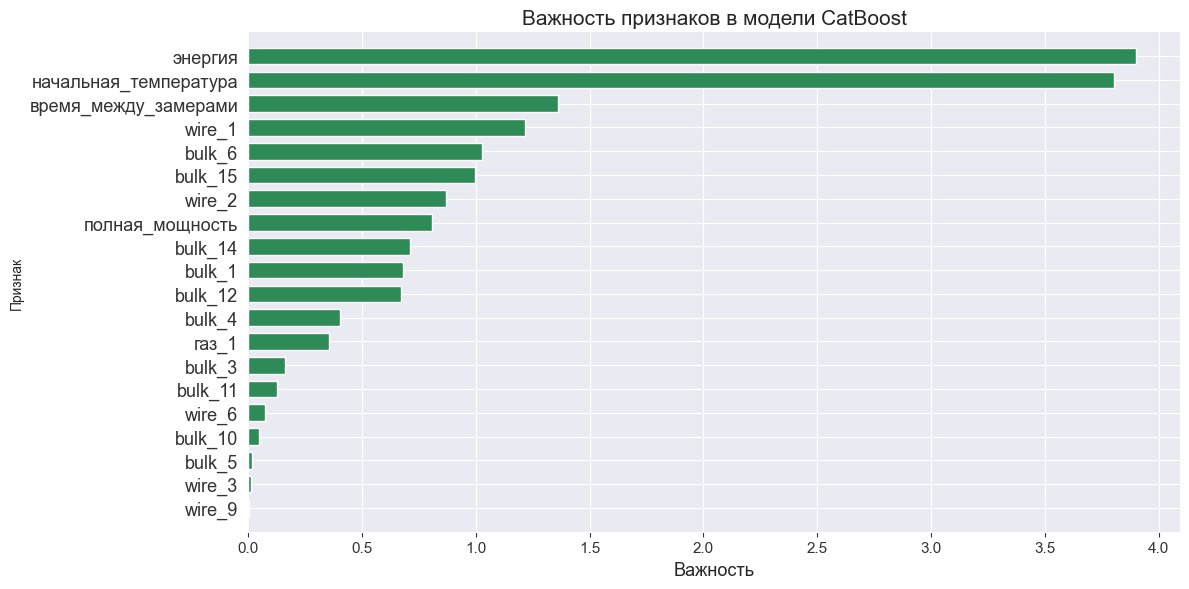

In [86]:
fig, ax = plt.subplots(figsize=(12, 6)) 

explainer = shap.TreeExplainer(best_catboost_model)

shap_values = explainer.shap_values(features_train)

shap.summary_plot(shap_values, features_train, plot_type="bar", color='seagreen', show=False, plot_size=None)
plt.title('Важность признаков в модели CatBoost', fontsize=15)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Мы видим, что самым главными признаками для обучения были `начальная температура` и `энергия`. Никак на обучение не повлиял признак `wire_9`.

<h2><a id="chapter6"></a>Итоговый вывод</h2>

В данном блоке проекта мы, основываясь на значении ошибки MAE, подобрали лучшую модель машинного обучения - CatBoost, которая показала на тренировочной выборке результат `MAE=6.415378`, а на тестовой `MAE=5.95` с гиперпараметрами `n_estimators=700, learning_rate 0.05, l2_leaf_reg=3, depth=4.`

Также мы рассмотрели важность признаков для модели и узнали, что самыми важными признаками были `начальная температура` и `энергия`.

<h3>Характеристики модели

Для оучения моделей мы использовали 22 признака:
- `начальная температура`	
- `время между замерами`	
- `полная мощность`
- `энергия`
- `bulk 1`, `bulk 3`, `bulk 4`, `bulk 5`, `bulk 6`, `bulk 10`, `bulk 11`, `bulk 12`, `bulk 14`, `bulk 15`
- `wire 1`, `wire 2`, `wire 3`, `wire 6`, `wire 9`
- `газ 1`

При чем самыми важными для обучения оказались признаки `энергия` и `начальная температура`.

Была проведена следующая предобработка признаков:

- `начальная температура`: удалили все записи по `key`, где встречалась температура ниже 1400
- `время между замерами`: получили из разности последнего времени замера и первого
- `полная мощность`: получили по формуле $ S = \sqrt{{\text{активная мощность}}^2 + {\text{реактивная мощность}}^2}$
- `энергия`: получили по формуле $длительность нагрева * активная мощность$
- `bulk`: удалили столбцы с материалами, которые использовали менее 30 раз и материалы с высокой корреляцией
- `wire`: то же, что и с `bulk`
- `газ 1`: не предобрабатывали

Гиперпараметры лучшей модели: `n_estimators=700, learning_rate 0.05, l2_leaf_reg=3, depth=4`, `random_state=61023`

Рекомендации для улучшения модели:

- Обращать внимание на корреляцию между признаками, стараться избегать мультиколлинеарности
- Изучать важность признаков обученных моделей
- Следить за переобучением линейных моделей

Рекомендации для улучшения решения/подхода к задаче:

- Переосмысление подхода: Вместо точного предсказания температуры можно сосредоточиться на уменьшении её колебаний. Определив допустимые границы колебания температуры и фиксируя случаи, когда она выходит за эти границы, можно перевести задачу из регрессии в классификацию. Тогда, при выявлении аномальных значений надо будет проводить детальный анализ условий производства в тот момент: используемые материалы, химический состав, бригады и так далее. А после анализа данных можно применять различные модели для выявления зависимостей и корреляций, влияющих на температуру, чтобы разработать конкретные мероприятия для контроля температуры и снижения энергопотребления.